In [4]:
import glob
import numpy as np
import cv2
import random
import torch
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms

# Define the video dataset class
class VideoDataset(Dataset):
    def __init__(self, video_files, labels, sequence_length=60, transform=None):
        self.video_files = video_files
        self.labels = labels
        self.transform = transform
        self.sequence_length = sequence_length

    def __len__(self):
        return len(self.video_files)

   
    def __getitem__(self, idx):
        video_path = self.video_files[idx]
        frames = []
        cap = cv2.VideoCapture(video_path)

        if not cap.isOpened():
            print(f"Failed to open video file: {video_path}")
            return torch.zeros(1), self.labels[idx]  # Return a default tensor

        frame_count = 0
        while True:
            success, frame = cap.read()
            if not success:
                break  # End of video or error reading frame
            frame_count += 1
        
        

            if self.transform:
                frame = self.transform(frame)
        
            frames.append(frame)
    
        cap.release()

        if frame_count == 0:
            print(f"No frames read from video file: {video_path}")
            return torch.zeros(1), self.labels[idx]  # Return a default tensor

        label = self.labels[idx]
        frames_tensor = torch.stack(frames)  # Convert frames to tensor

        return frames_tensor, label
        

# Define data directories
real_videos_dir = '/kaggle/input/deepfake-extracted/Real-20240509T005638Z-001/Real'
fake_videos_dir = '/kaggle/input/deepfake-extracted/Fake-20240509T003929Z-001/Fake'

# Load video files from directories
real_video_files = glob.glob(real_videos_dir + '/*.mp4')
fake_video_files = glob.glob(fake_videos_dir + '/*.mp4')

# Shuffle the lists of video files
random.shuffle(real_video_files)
random.shuffle(fake_video_files)

# Combine real and fake video files
video_files = real_video_files + fake_video_files

# Create labels (0 for fake videos, 1 for real videos)
labels = [1] * len(real_video_files) + [0] * len(fake_video_files)

# Shuffle video files and labels together
combined = list(zip(video_files, labels))
random.shuffle(combined)
video_files, labels = zip(*combined)




In [5]:
import matplotlib.pyplot as plt
def im_plot(tensor):
    image = tensor.cpu().numpy().transpose(1,2,0)
    b,g,r = cv2.split(image)
    image = cv2.merge((r,g,b))
    image = image*[0.22803, 0.22145, 0.216989] +  [0.43216, 0.394666, 0.37645]
    image = image*255.0
    plt.imshow(image.astype(int))
    plt.show()

In [8]:
#count the number of fake and real videos
import os

def number_of_real_and_fake_videos(real_videos_dir, fake_videos_dir):
    real_video_files = glob.glob(real_videos_dir + '/*.mp4')
    fake_video_files = glob.glob(fake_videos_dir + '/*.mp4')
    real = len(real_video_files)
    fake = len(fake_video_files)
    return real, fake

#ou can call this function with your directory paths to get the counts of real and fake videos:
#real_videos_dir = '/content/drive/My Drive/Real'
#fake_videos_dir = '/content/drive/My Drive/Fake'
#real_count, fake_count = number_of_real_and_fake_videos(real_videos_dir, fake_videos_dir)
#print("Number of real videos:", real_count)
#print("Number of fake videos:", fake_count)



In [9]:
import torch
import torchvision.transforms as transforms
from PIL import Image

# Assuming you have a tensor named 'frame' representing a single frame
# Replace 'frame' with your actual tensor variable containing the frame data

# Convert the tensor to a NumPy array
frame_np = frame.cpu().numpy()  # Assuming frame is on the CPU
frame_np = frame_np.astype(np.float32)  # Convert to float32 data type if necessary

# Rescale pixel values to [0, 1] if necessary
frame_np = frame_np / 255.0  # Assuming pixel values are in the range [0, 255]

# Transpose the dimensions if necessary
frame_np = np.transpose(frame_np, (1, 2, 0))

# Create a PIL Image object
image = Image.fromarray((frame_np * 255).astype(np.uint8))  # Ensure the data type is uint8

# Now 'image' contains the PIL Image object representing the frame


NameError: name 'frame' is not defined

In [10]:
import torch
import torchvision.transforms as transforms

def custom_collate(batch):
    inputs, targets = zip(*batch)
    resized_inputs = []
    resized_targets = []
    
    # Find the maximum length among the sequences
    max_length = max(len(seq) for seq in inputs)
    
    for seq, target in zip(inputs, targets):
        resized_seq = []
        tensor_frame = torch.zeros(3, 112, 112)  # Initialize with a tensor of zeros
        for frame in seq:
            if frame.ndimension() != 0:  # Check if the frame has non-zero dimensions
                pil_frame = transforms.ToPILImage()(frame)
                resized_frame = transforms.Resize((112, 112))(pil_frame)
                tensor_frame = transforms.ToTensor()(resized_frame)
                resized_seq.append(tensor_frame)
        
        # Pad or truncate the sequence to the maximum length
        while len(resized_seq) < max_length:
            # Pad the sequence with zeros
            resized_seq.append(torch.zeros_like(tensor_frame))
        if len(resized_seq) > max_length:
            # Truncate the sequence
            resized_seq = resized_seq[:max_length]
        
        resized_inputs.append(resized_seq)
        resized_targets.append(target)

    # Convert resized sequences to tensors
    inputs = torch.stack([torch.stack(seq) for seq in resized_inputs])
    targets = torch.tensor(resized_targets, dtype=torch.long)
    
    return inputs, targets


Train: 1659
Validation: 416


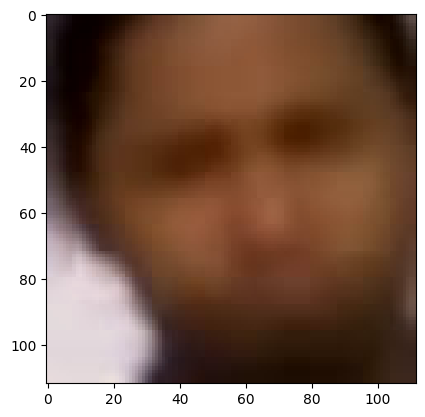

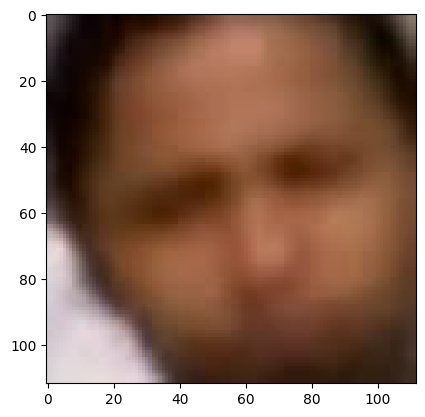

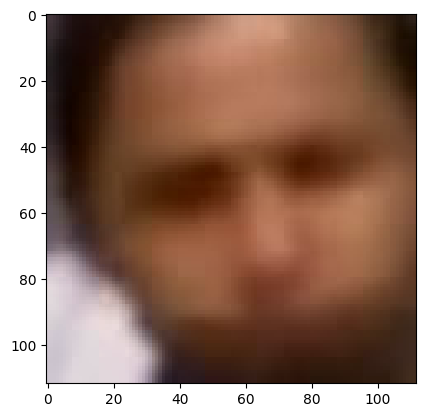

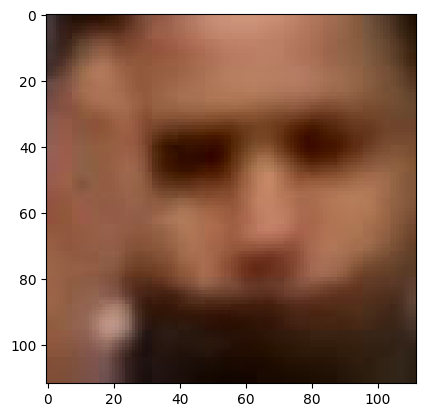

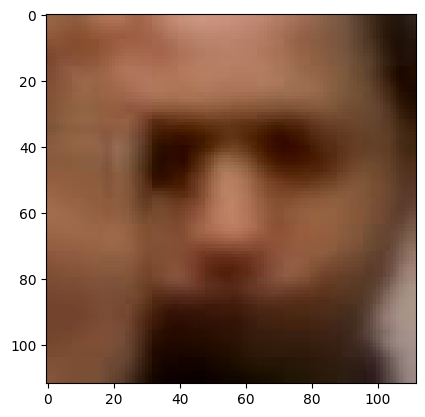

In [11]:
import random
import pandas as pd
from torch.utils.data import DataLoader
from torchvision import transforms

# Assuming number_of_real_and_fake_videos, custom_collate, VideoDataset, and im_plot are defined elsewhere
# Ensure you have the necessary imports
import os

# Define function to count number of real and fake videos
def number_of_real_and_fake_videos(real_videos_dir, fake_videos_dir):
    num_real_videos = len(os.listdir(real_videos_dir))
    num_fake_videos = len(os.listdir(fake_videos_dir))
    return num_real_videos, num_fake_videos

# Load video files and labels (assuming 'combined' is a list of tuples (video_path, label))
# e.g., combined = [(video1_path, label1), (video2_path, label2), ...]

# Define data directories
real_videos_dir = '/kaggle/input/deepfake-extracted/Real-20240509T005638Z-001/Real'
fake_videos_dir = '/kaggle/input/deepfake-extracted/Fake-20240509T003929Z-001/Fake'

# Calculate the number of real and fake videos
num_real_videos, num_fake_videos = number_of_real_and_fake_videos(real_videos_dir, fake_videos_dir)

# Split the dataset into training and validation sets
train_ratio = 0.8
num_train_real = int(train_ratio * num_real_videos)
num_train_fake = int(train_ratio * num_fake_videos)

# Split the combined list
real_videos = [(video, label) for video, label in combined if label == 1]
fake_videos = [(video, label) for video, label in combined if label == 0]

train_videos = real_videos[:num_train_real] + fake_videos[:num_train_fake]
valid_videos = real_videos[num_train_real:] + fake_videos[num_train_fake:]

train_video_paths, train_labels = zip(*train_videos)
valid_video_paths, valid_labels = zip(*valid_videos)

print("Train:", len(train_video_paths))
print("Validation:", len(valid_video_paths))

im_size = 112
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
# Define transformations
train_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((im_size, im_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

valid_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((im_size, im_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

# Create datasets and data loaders
train_data = VideoDataset(train_video_paths, train_labels, sequence_length=10, transform=train_transforms)
valid_data = VideoDataset(valid_video_paths, valid_labels, sequence_length=10, transform=valid_transforms)

train_loader = DataLoader(train_data, batch_size=4, shuffle=True, num_workers=4, collate_fn=custom_collate)
valid_loader = DataLoader(valid_data, batch_size=4, shuffle=True, num_workers=4,collate_fn=custom_collate)



# Example visualization
frames, label = train_data[0]
for frame in frames:
    im_plot(frame)

In [12]:
from torch import nn
from torchvision import models
class Model(nn.Module):
    def __init__(self, num_classes,latent_dim= 2048, lstm_layers=1 , hidden_dim = 2048, bidirectional = False):
        super(Model, self).__init__()
        model = models.resnext50_32x4d(pretrained = True) #Residual Network CNN
        self.model = nn.Sequential(*list(model.children())[:-2])
        self.lstm = nn.LSTM(latent_dim,hidden_dim, lstm_layers,  bidirectional)
        self.relu = nn.LeakyReLU()
        self.dp = nn.Dropout(0.4)
        self.linear1 = nn.Linear(2048,num_classes)
        self.avgpool = nn.AdaptiveAvgPool2d(1)
    def forward(self, x):
        batch_size,seq_length, c, h, w = x.shape
        x = x.view(batch_size * seq_length, c, h, w)
        fmap = self.model(x)
        x = self.avgpool(fmap)
        x = x.view(batch_size,seq_length,2048)
        x_lstm,_ = self.lstm(x,None)
        return fmap,self.dp(self.linear1(torch.mean(x_lstm,dim = 1)))

In [13]:
model = Model(2).cuda()
a,b = model(torch.from_numpy(np.empty((1,20,3,112,112))).type(torch.cuda.FloatTensor))

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNeXt50_32X4D_Weights.IMAGENET1K_V1`. You can also use `weights=ResNeXt50_32X4D_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnext50_32x4d-7cdf4587.pth" to /root/.cache/torch/hub/checkpoints/resnext50_32x4d-7cdf4587.pth
100%|██████████| 95.8M/95.8M [00:00<00:00, 142MB/s] 


In [14]:
import torch

# Check if CUDA is available
if torch.cuda.is_available():
    device = torch.device("cuda")  # Use GPU
    print("CUDA is available. Using GPU.")
else:
    device = torch.device("cpu")   # Use CPU
    print("CUDA is not available. Using CPU.")

CUDA is available. Using GPU.


In [16]:
from sklearn.metrics import confusion_matrix
import torch
from torch.autograd import Variable
import time
import os
import sys
import os
import os
import torch
import sys
import torch.nn as nn
from torch.optim.lr_scheduler import ReduceLROnPlateau  # Added import

def train_epoch(epoch, num_epochs, data_loader, model, criterion, optimizer):
    model.train()
    losses = AverageMeter()
    accuracies = AverageMeter()
    
    for i, (inputs, targets) in enumerate(data_loader):
        if torch.cuda.is_available():
            targets = targets.type(torch.cuda.LongTensor)
            inputs = inputs.cuda()
        
        _, outputs = model(inputs)
        loss = criterion(outputs, targets.type(torch.cuda.LongTensor))
        acc = calculate_accuracy(outputs, targets.type(torch.cuda.LongTensor))
        
        losses.update(loss.item(), inputs.size(0))
        accuracies.update(acc, inputs.size(0))
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        sys.stdout.write(
            "\r[Epoch %d/%d] [Batch %d / %d] [Loss: %f, Acc: %.2f%%]"
            % (
                epoch,
                num_epochs,
                i + 1,
                len(data_loader),
                losses.avg,
                accuracies.avg))
        sys.stdout.flush()

    # Save model checkpoint
    save_dir = '/kaggle/working'
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    torch.save(model.state_dict(), os.path.join(save_dir, 'checkpoint.pt'))

    return losses.avg, accuracies.avg


def test(epoch, model, data_loader, criterion):
    print('Testing')
    model.eval()
    losses = AverageMeter()
    accuracies = AverageMeter()
    pred = []
    true = []
    count = 0
    with torch.no_grad():
        for i, (inputs, targets) in enumerate(data_loader):
            if torch.cuda.is_available():
                targets = targets.cuda().type(torch.cuda.FloatTensor)
                inputs = inputs.cuda()
            _,outputs = model(inputs)
            loss = torch.mean(criterion(outputs, targets.type(torch.cuda.LongTensor)))
            acc = calculate_accuracy(outputs,targets.type(torch.cuda.LongTensor))
            _,p = torch.max(outputs,1)
            true += (targets.type(torch.cuda.LongTensor)).detach().cpu().numpy().reshape(len(targets)).tolist()
            pred += p.detach().cpu().numpy().reshape(len(p)).tolist()
            losses.update(loss.item(), inputs.size(0))
            accuracies.update(acc, inputs.size(0))
            sys.stdout.write(
                    "\r[Batch %d / %d]  [Loss: %f, Acc: %.2f%%]"
                    % (
                        i,
                        len(data_loader),
                        losses.avg,
                        accuracies.avg
                        )
                    )
        print('\nAccuracy {}'.format(accuracies.avg))
    return true, pred, losses.avg, accuracies.avg

class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()
    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

def calculate_accuracy(outputs, targets):
    batch_size = targets.size(0)

    _, pred = outputs.topk(1, 1, True)
    pred = pred.t()
    correct = pred.eq(targets.view(1, -1))
    n_correct_elems = correct.float().sum().item()
    return 100 * n_correct_elems / batch_size


In [17]:
import seaborn as sn
#Output confusion matrix
def print_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    print('True positive = ', cm[0][0])
    print('False positive = ', cm[0][1])
    print('False negative = ', cm[1][0])
    print('True negative = ', cm[1][1])
    print('\n')
    df_cm = pd.DataFrame(cm, range(2), range(2))
    sn.set(font_scale=1.4) # for label size
    sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}) # font size
    plt.ylabel('Actual label', size = 20)
    plt.xlabel('Predicted label', size = 20)
    plt.xticks(np.arange(2), ['Fake', 'Real'], size = 16)
    plt.yticks(np.arange(2), ['Fake', 'Real'], size = 16)
    plt.ylim([2, 0])
    plt.show()
    calculated_acc = (cm[0][0]+cm[1][1])/(cm[0][0]+cm[0][1]+cm[1][0]+ cm[1][1])
    print("Calculated Accuracy",calculated_acc*100)

In [18]:
def plot_loss(train_loss_avg,test_loss_avg,num_epochs):
  loss_train = train_loss_avg
  loss_val = test_loss_avg
  print(num_epochs)
  epochs = range(1,num_epochs+1)
  plt.plot(epochs, loss_train, 'g', label='Training loss')
  plt.plot(epochs, loss_val, 'b', label='validation loss')
  plt.title('Training and Validation loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  plt.show()
def plot_accuracy(train_accuracy,test_accuracy,num_epochs):
  loss_train = train_accuracy
  loss_val = test_accuracy
  epochs = range(1,num_epochs+1)
  plt.plot(epochs, loss_train, 'g', label='Training accuracy')
  plt.plot(epochs, loss_val, 'b', label='validation accuracy')
  plt.title('Training and Validation accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend()
  plt.show()

[Epoch 1/15] [Batch 12 / 415] [Loss: 0.644546, Acc: 62.50%]Failed to open video file: /kaggle/input/deepfake-extracted/Fake-20240509T003929Z-001/Fake/28_05__walking_down_street_outside_angry__W3J028UG.mp4


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x5b3acd81bf00] moov atom not found


[Epoch 1/15] [Batch 124 / 415] [Loss: 0.558641, Acc: 77.82%]Failed to open video file: /kaggle/input/deepfake-extracted/Fake-20240509T003929Z-001/Fake/12_07__walking_outside_cafe_disgusted__KAG65PEE(1).mp4


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x5b3acd819900] moov atom not found


[Epoch 1/15] [Batch 128 / 415] [Loss: 0.565753, Acc: 77.54%]Failed to open video file: /kaggle/input/deepfake-extracted/Fake-20240509T003929Z-001/Fake/09_20__kitchen_pan__98NUQ3E6.mp4


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x5b3acd827c80] moov atom not found


[Epoch 1/15] [Batch 141 / 415] [Loss: 0.557473, Acc: 78.01%]Failed to open video file: /kaggle/input/deepfake-extracted/Fake-20240509T003929Z-001/Fake/21_12__walking_and_outside_surprised__J54W3PV1.mp4


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x5b3ade469b80] moov atom not found


[Epoch 1/15] [Batch 205 / 415] [Loss: 0.538876, Acc: 80.00%]Failed to open video file: /kaggle/input/deepfake-extracted/Fake-20240509T003929Z-001/Fake/05_28__kitchen_still__W3J028UG.mp4


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x5b3acd821440] moov atom not found


[Epoch 1/15] [Batch 277 / 415] [Loss: 0.540688, Acc: 80.32%]Failed to open video file: /kaggle/input/deepfake-extracted/Fake-20240509T003929Z-001/Fake/15_04__talking_angry_couch__46TJ9IOJ(1).mp4


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x5b3adaf20580] moov atom not found


[Epoch 1/15] [Batch 278 / 415] [Loss: 0.541059, Acc: 80.31%]Failed to open video file: /kaggle/input/deepfake-extracted/Fake-20240509T003929Z-001/Fake/07_03__podium_speech_happy__6PHZRQ4H.mp4


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x5b3acd826900] moov atom not found


[Epoch 1/15] [Batch 287 / 415] [Loss: 0.536740, Acc: 80.66%]Failed to open video file: /kaggle/input/deepfake-extracted/Real-20240509T005638Z-001/Real/05__walk_down_hall_angry.mp4
[Epoch 1/15] [Batch 340 / 415] [Loss: 0.532626, Acc: 80.81%]Failed to open video file: /kaggle/input/deepfake-extracted/Real-20240509T005638Z-001/Real/18__outside_talking_pan_laughing.mp4


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x5b3acd81bf00] moov atom not found


[Epoch 1/15] [Batch 343 / 415] [Loss: 0.531333, Acc: 80.90%]Failed to open video file: /kaggle/input/deepfake-extracted/Real-20240509T005638Z-001/Real/18__walk_down_hall_angry.mp4
[Epoch 1/15] [Batch 378 / 415] [Loss: 0.527038, Acc: 80.95%]Failed to open video file: /kaggle/input/deepfake-extracted/Real-20240509T005638Z-001/Real/02__walk_down_hall_angry.mp4
Failed to open video file: /kaggle/input/deepfake-extracted/Fake-20240509T003929Z-001/Fake/13_14__kitchen_still__KMQ3AW6A.mp4


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x5b3addf93cc0] moov atom not found


[Epoch 1/15] [Batch 415 / 415] [Loss: 0.513712, Acc: 81.56%]Testing
Failed to open video file: /kaggle/input/deepfake-extracted/Fake-20240509T003929Z-001/Fake/07_09__outside_talking_still_laughing__N9CWME71.mp4


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x5b3aece14880] moov atom not found


[Batch 43 / 104]  [Loss: 0.408034, Acc: 84.66%]Failed to open video file: /kaggle/input/deepfake-extracted/Real-20240509T005638Z-001/Real/17__walking_down_street_outside_angry.mp4
[Batch 50 / 104]  [Loss: 0.396799, Acc: 85.29%]Failed to open video file: /kaggle/input/deepfake-extracted/Fake-20240509T003929Z-001/Fake/18_15__walking_down_street_outside_angry__V5VHLCOW.mp4


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x5b3aecd965c0] moov atom not found


[Batch 55 / 104]  [Loss: 0.413563, Acc: 83.48%]Failed to open video file: /kaggle/input/deepfake-extracted/Fake-20240509T003929Z-001/Fake/07_09__secret_conversation__N9CWME71.mp4
[Batch 78 / 104]  [Loss: 0.419844, Acc: 83.54%]Failed to open video file: /kaggle/input/deepfake-extracted/Fake-20240509T003929Z-001/Fake/03_07__walk_down_hall_angry__6PHZRQ4H.mp4
[Batch 91 / 104]  [Loss: 0.434906, Acc: 82.07%]Failed to open video file: /kaggle/input/deepfake-extracted/Fake-20240509T003929Z-001/Fake/21_03__exit_phone_room__V53E3RVB.mp4
[Batch 93 / 104]  [Loss: 0.438359, Acc: 81.91%]

[mov,mp4,m4a,3gp,3g2,mj2 @ 0x5b3aecd965c0] moov atom not found


[Batch 103 / 104]  [Loss: 0.431305, Acc: 82.45%]
Accuracy 82.45192307692308
Epoch 1: Current learning rate is 0.001
[Epoch 2/15] [Batch 51 / 415] [Loss: 0.505876, Acc: 82.84%]Failed to open video file: /kaggle/input/deepfake-extracted/Fake-20240509T003929Z-001/Fake/07_03__podium_speech_happy__6PHZRQ4H.mp4


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x5b3af5cb8e80] moov atom not found


[Epoch 2/15] [Batch 70 / 415] [Loss: 0.481102, Acc: 83.21%]Failed to open video file: /kaggle/input/deepfake-extracted/Real-20240509T005638Z-001/Real/02__walk_down_hall_angry.mp4
[Epoch 2/15] [Batch 124 / 415] [Loss: 0.495860, Acc: 82.26%]Failed to open video file: /kaggle/input/deepfake-extracted/Fake-20240509T003929Z-001/Fake/05_28__kitchen_still__W3J028UG.mp4


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x5b3aef562fc0] moov atom not found


[Epoch 2/15] [Batch 161 / 415] [Loss: 0.471846, Acc: 83.54%]Failed to open video file: /kaggle/input/deepfake-extracted/Fake-20240509T003929Z-001/Fake/21_12__walking_and_outside_surprised__J54W3PV1.mp4


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x5b3aef40c6c0] moov atom not found


[Epoch 2/15] [Batch 170 / 415] [Loss: 0.476240, Acc: 83.24%]Failed to open video file: /kaggle/input/deepfake-extracted/Fake-20240509T003929Z-001/Fake/12_07__walking_outside_cafe_disgusted__KAG65PEE(1).mp4


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x5b3aef2ab100] moov atom not found


[Epoch 2/15] [Batch 182 / 415] [Loss: 0.470345, Acc: 83.65%]Failed to open video file: /kaggle/input/deepfake-extracted/Fake-20240509T003929Z-001/Fake/28_05__walking_down_street_outside_angry__W3J028UG.mp4


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x5b3acd82c680] moov atom not found


[Epoch 2/15] [Batch 213 / 415] [Loss: 0.481641, Acc: 83.45%]Failed to open video file: /kaggle/input/deepfake-extracted/Real-20240509T005638Z-001/Real/18__outside_talking_pan_laughing.mp4


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x5b3aef2ab600] moov atom not found


[Epoch 2/15] [Batch 221 / 415] [Loss: 0.480691, Acc: 83.26%]Failed to open video file: /kaggle/input/deepfake-extracted/Fake-20240509T003929Z-001/Fake/09_20__kitchen_pan__98NUQ3E6.mp4


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x5b3aef2ab600] moov atom not found


[Epoch 2/15] [Batch 293 / 415] [Loss: 0.472689, Acc: 82.68%]Failed to open video file: /kaggle/input/deepfake-extracted/Real-20240509T005638Z-001/Real/05__walk_down_hall_angry.mp4
[Epoch 2/15] [Batch 313 / 415] [Loss: 0.474322, Acc: 82.35%]Failed to open video file: /kaggle/input/deepfake-extracted/Fake-20240509T003929Z-001/Fake/13_14__kitchen_still__KMQ3AW6A.mp4


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x5b3aeeed7600] moov atom not found


[Epoch 2/15] [Batch 367 / 415] [Loss: 0.468116, Acc: 82.56%]Failed to open video file: /kaggle/input/deepfake-extracted/Fake-20240509T003929Z-001/Fake/15_04__talking_angry_couch__46TJ9IOJ(1).mp4


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x5b3aef3eaec0] moov atom not found


[Epoch 2/15] [Batch 399 / 415] [Loss: 0.465248, Acc: 83.02%]Failed to open video file: /kaggle/input/deepfake-extracted/Real-20240509T005638Z-001/Real/18__walk_down_hall_angry.mp4
[Epoch 2/15] [Batch 415 / 415] [Loss: 0.463637, Acc: 83.24%]Testing
[Batch 3 / 104]  [Loss: 0.453080, Acc: 75.00%]Failed to open video file: /kaggle/input/deepfake-extracted/Fake-20240509T003929Z-001/Fake/21_03__exit_phone_room__V53E3RVB.mp4
Failed to open video file: /kaggle/input/deepfake-extracted/Fake-20240509T003929Z-001/Fake/07_09__secret_conversation__N9CWME71.mp4
[Batch 5 / 104]  [Loss: 0.392583, Acc: 79.17%]

[mov,mp4,m4a,3gp,3g2,mj2 @ 0x5b3aefa23d80] moov atom not found


[Batch 15 / 104]  [Loss: 0.364484, Acc: 79.69%]Failed to open video file: /kaggle/input/deepfake-extracted/Fake-20240509T003929Z-001/Fake/18_15__walking_down_street_outside_angry__V5VHLCOW.mp4
[Batch 17 / 104]  [Loss: 0.331174, Acc: 81.94%]Failed to open video file: /kaggle/input/deepfake-extracted/Real-20240509T005638Z-001/Real/17__walking_down_street_outside_angry.mp4


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x5b3aef3ebc80] moov atom not found


[Batch 26 / 104]  [Loss: 0.360316, Acc: 81.48%]Failed to open video file: /kaggle/input/deepfake-extracted/Fake-20240509T003929Z-001/Fake/07_09__outside_talking_still_laughing__N9CWME71.mp4


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x5b3aef152740] moov atom not found


[Batch 92 / 104]  [Loss: 0.319907, Acc: 83.87%]Failed to open video file: /kaggle/input/deepfake-extracted/Fake-20240509T003929Z-001/Fake/03_07__walk_down_hall_angry__6PHZRQ4H.mp4
[Batch 103 / 104]  [Loss: 0.323178, Acc: 83.89%]
Accuracy 83.89423076923077
Epoch 2: Current learning rate is 0.001
[Epoch 3/15] [Batch 19 / 415] [Loss: 0.516902, Acc: 85.53%]Failed to open video file: /kaggle/input/deepfake-extracted/Fake-20240509T003929Z-001/Fake/12_07__walking_outside_cafe_disgusted__KAG65PEE(1).mp4


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x5b3adaf35b00] moov atom not found


[Epoch 3/15] [Batch 22 / 415] [Loss: 0.517679, Acc: 84.09%]Failed to open video file: /kaggle/input/deepfake-extracted/Fake-20240509T003929Z-001/Fake/28_05__walking_down_street_outside_angry__W3J028UG.mp4


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x5b3acd79e5c0] moov atom not found


[Epoch 3/15] [Batch 37 / 415] [Loss: 0.498060, Acc: 79.73%]Failed to open video file: /kaggle/input/deepfake-extracted/Fake-20240509T003929Z-001/Fake/05_28__kitchen_still__W3J028UG.mp4


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x5b3aefd549c0] moov atom not found


[Epoch 3/15] [Batch 93 / 415] [Loss: 0.418973, Acc: 84.68%]Failed to open video file: /kaggle/input/deepfake-extracted/Real-20240509T005638Z-001/Real/02__walk_down_hall_angry.mp4
[Epoch 3/15] [Batch 127 / 415] [Loss: 0.417430, Acc: 84.65%]Failed to open video file: /kaggle/input/deepfake-extracted/Real-20240509T005638Z-001/Real/05__walk_down_hall_angry.mp4
[Epoch 3/15] [Batch 172 / 415] [Loss: 0.398575, Acc: 85.76%]Failed to open video file: /kaggle/input/deepfake-extracted/Fake-20240509T003929Z-001/Fake/13_14__kitchen_still__KMQ3AW6A.mp4
Failed to open video file: /kaggle/input/deepfake-extracted/Fake-20240509T003929Z-001/Fake/07_03__podium_speech_happy__6PHZRQ4H.mp4


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x5b3af0255940] moov atom not found
[mov,mp4,m4a,3gp,3g2,mj2 @ 0x5b3af0255940] moov atom not found


[Epoch 3/15] [Batch 195 / 415] [Loss: 0.396501, Acc: 85.51%]Failed to open video file: /kaggle/input/deepfake-extracted/Real-20240509T005638Z-001/Real/18__outside_talking_pan_laughing.mp4


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x5b3acd33c8c0] moov atom not found


[Epoch 3/15] [Batch 263 / 415] [Loss: 0.385999, Acc: 86.98%]Failed to open video file: /kaggle/input/deepfake-extracted/Fake-20240509T003929Z-001/Fake/15_04__talking_angry_couch__46TJ9IOJ(1).mp4


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x5b3aefdb1200] moov atom not found


[Epoch 3/15] [Batch 332 / 415] [Loss: 0.373430, Acc: 87.27%]Failed to open video file: /kaggle/input/deepfake-extracted/Fake-20240509T003929Z-001/Fake/09_20__kitchen_pan__98NUQ3E6.mp4
Failed to open video file: /kaggle/input/deepfake-extracted/Fake-20240509T003929Z-001/Fake/21_12__walking_and_outside_surprised__J54W3PV1.mp4


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x5b3adaf20580] moov atom not found
[mov,mp4,m4a,3gp,3g2,mj2 @ 0x5b3af0256dc0] moov atom not found


[Epoch 3/15] [Batch 391 / 415] [Loss: 0.371117, Acc: 87.15%]Failed to open video file: /kaggle/input/deepfake-extracted/Real-20240509T005638Z-001/Real/18__walk_down_hall_angry.mp4
[Epoch 3/15] [Batch 415 / 415] [Loss: 0.370100, Acc: 87.22%]Testing
Failed to open video file: /kaggle/input/deepfake-extracted/Fake-20240509T003929Z-001/Fake/07_09__outside_talking_still_laughing__N9CWME71.mp4


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x5b3aef832a40] moov atom not found


[Batch 5 / 104]  [Loss: 0.251105, Acc: 91.67%]]Failed to open video file: /kaggle/input/deepfake-extracted/Fake-20240509T003929Z-001/Fake/21_03__exit_phone_room__V53E3RVB.mp4


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x5b3aef832a40] moov atom not found


[Batch 53 / 104]  [Loss: 0.261292, Acc: 87.96%]Failed to open video file: /kaggle/input/deepfake-extracted/Fake-20240509T003929Z-001/Fake/03_07__walk_down_hall_angry__6PHZRQ4H.mp4
[Batch 78 / 104]  [Loss: 0.261259, Acc: 88.92%]Failed to open video file: /kaggle/input/deepfake-extracted/Fake-20240509T003929Z-001/Fake/07_09__secret_conversation__N9CWME71.mp4
Failed to open video file: /kaggle/input/deepfake-extracted/Real-20240509T005638Z-001/Real/17__walking_down_street_outside_angry.mp4
[Batch 86 / 104]  [Loss: 0.259415, Acc: 88.79%]Failed to open video file: /kaggle/input/deepfake-extracted/Fake-20240509T003929Z-001/Fake/18_15__walking_down_street_outside_angry__V5VHLCOW.mp4
[Batch 88 / 104]  [Loss: 0.261018, Acc: 89.04%]

[mov,mp4,m4a,3gp,3g2,mj2 @ 0x5b3aef832a40] moov atom not found


[Batch 103 / 104]  [Loss: 0.257557, Acc: 89.66%]
Accuracy 89.66346153846153
Epoch 3: Current learning rate is 0.001
[Epoch 4/15] [Batch 15 / 415] [Loss: 0.328514, Acc: 90.00%]Failed to open video file: /kaggle/input/deepfake-extracted/Fake-20240509T003929Z-001/Fake/15_04__talking_angry_couch__46TJ9IOJ(1).mp4


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x5b3af0622b40] moov atom not found


[Epoch 4/15] [Batch 17 / 415] [Loss: 0.323329, Acc: 86.76%]Failed to open video file: /kaggle/input/deepfake-extracted/Fake-20240509T003929Z-001/Fake/07_03__podium_speech_happy__6PHZRQ4H.mp4


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x5b3adaf20580] moov atom not found


[Epoch 4/15] [Batch 36 / 415] [Loss: 0.289306, Acc: 89.58%]Failed to open video file: /kaggle/input/deepfake-extracted/Fake-20240509T003929Z-001/Fake/28_05__walking_down_street_outside_angry__W3J028UG.mp4


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x5b3af08505c0] moov atom not found


[Epoch 4/15] [Batch 41 / 415] [Loss: 0.271540, Acc: 90.85%]Failed to open video file: /kaggle/input/deepfake-extracted/Fake-20240509T003929Z-001/Fake/12_07__walking_outside_cafe_disgusted__KAG65PEE(1).mp4


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x5b3af074fc00] moov atom not found


[Epoch 4/15] [Batch 140 / 415] [Loss: 0.303649, Acc: 90.36%]Failed to open video file: /kaggle/input/deepfake-extracted/Real-20240509T005638Z-001/Real/18__walk_down_hall_angry.mp4
[Epoch 4/15] [Batch 287 / 415] [Loss: 0.295484, Acc: 90.07%]Failed to open video file: /kaggle/input/deepfake-extracted/Real-20240509T005638Z-001/Real/02__walk_down_hall_angry.mp4
[Epoch 4/15] [Batch 322 / 415] [Loss: 0.297742, Acc: 89.91%]Failed to open video file: /kaggle/input/deepfake-extracted/Fake-20240509T003929Z-001/Fake/09_20__kitchen_pan__98NUQ3E6.mp4


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x5b3acd79e5c0] moov atom not found


[Epoch 4/15] [Batch 331 / 415] [Loss: 0.296962, Acc: 90.11%]Failed to open video file: /kaggle/input/deepfake-extracted/Real-20240509T005638Z-001/Real/18__outside_talking_pan_laughing.mp4


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x5b3aefcd7c00] moov atom not found


[Epoch 4/15] [Batch 384 / 415] [Loss: 0.301760, Acc: 90.30%]Failed to open video file: /kaggle/input/deepfake-extracted/Fake-20240509T003929Z-001/Fake/13_14__kitchen_still__KMQ3AW6A.mp4


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x5b3af084fe80] moov atom not found


[Epoch 4/15] [Batch 393 / 415] [Loss: 0.301420, Acc: 90.27%]Failed to open video file: /kaggle/input/deepfake-extracted/Real-20240509T005638Z-001/Real/05__walk_down_hall_angry.mp4
[Epoch 4/15] [Batch 401 / 415] [Loss: 0.302193, Acc: 90.27%]Failed to open video file: /kaggle/input/deepfake-extracted/Fake-20240509T003929Z-001/Fake/05_28__kitchen_still__W3J028UG.mp4


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x5b3af0621f00] moov atom not found


[Epoch 4/15] [Batch 403 / 415] [Loss: 0.305058, Acc: 90.20%]Failed to open video file: /kaggle/input/deepfake-extracted/Fake-20240509T003929Z-001/Fake/21_12__walking_and_outside_surprised__J54W3PV1.mp4


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x5b3aefcd7c00] moov atom not found


[Epoch 4/15] [Batch 415 / 415] [Loss: 0.302594, Acc: 90.30%]Testing
Failed to open video file: /kaggle/input/deepfake-extracted/Fake-20240509T003929Z-001/Fake/07_09__secret_conversation__N9CWME71.mp4
Failed to open video file: /kaggle/input/deepfake-extracted/Fake-20240509T003929Z-001/Fake/21_03__exit_phone_room__V53E3RVB.mp4
[Batch 1 / 104]  [Loss: 0.150391, Acc: 87.50%]]

[mov,mp4,m4a,3gp,3g2,mj2 @ 0x5b3adb163d40] moov atom not found


[Batch 30 / 104]  [Loss: 0.215414, Acc: 90.32%]Failed to open video file: /kaggle/input/deepfake-extracted/Fake-20240509T003929Z-001/Fake/03_07__walk_down_hall_angry__6PHZRQ4H.mp4
[Batch 56 / 104]  [Loss: 0.213579, Acc: 91.23%]Failed to open video file: /kaggle/input/deepfake-extracted/Fake-20240509T003929Z-001/Fake/07_09__outside_talking_still_laughing__N9CWME71.mp4


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x5b3adb406340] moov atom not found


[Batch 70 / 104]  [Loss: 0.211023, Acc: 91.20%]Failed to open video file: /kaggle/input/deepfake-extracted/Fake-20240509T003929Z-001/Fake/18_15__walking_down_street_outside_angry__V5VHLCOW.mp4
[Batch 72 / 104]  [Loss: 0.207172, Acc: 91.44%]

[mov,mp4,m4a,3gp,3g2,mj2 @ 0x5b3af03ae700] moov atom not found


Failed to open video file: /kaggle/input/deepfake-extracted/Real-20240509T005638Z-001/Real/17__walking_down_street_outside_angry.mp4
[Batch 103 / 104]  [Loss: 0.197740, Acc: 92.07%]
Accuracy 92.0673076923077
Epoch 4: Current learning rate is 0.001
[Epoch 5/15] [Batch 39 / 415] [Loss: 0.251573, Acc: 92.31%]Failed to open video file: /kaggle/input/deepfake-extracted/Fake-20240509T003929Z-001/Fake/15_04__talking_angry_couch__46TJ9IOJ(1).mp4


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x5b3adb15bf80] moov atom not found


[Epoch 5/15] [Batch 41 / 415] [Loss: 0.250785, Acc: 92.68%]Failed to open video file: /kaggle/input/deepfake-extracted/Fake-20240509T003929Z-001/Fake/28_05__walking_down_street_outside_angry__W3J028UG.mp4
Failed to open video file: /kaggle/input/deepfake-extracted/Fake-20240509T003929Z-001/Fake/09_20__kitchen_pan__98NUQ3E6.mp4


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x5b3af03ae700] moov atom not found
[mov,mp4,m4a,3gp,3g2,mj2 @ 0x5b3ae26d3800] moov atom not found


[Epoch 5/15] [Batch 87 / 415] [Loss: 0.312263, Acc: 89.66%]Failed to open video file: /kaggle/input/deepfake-extracted/Real-20240509T005638Z-001/Real/18__walk_down_hall_angry.mp4
[Epoch 5/15] [Batch 127 / 415] [Loss: 0.291342, Acc: 90.16%]Failed to open video file: /kaggle/input/deepfake-extracted/Real-20240509T005638Z-001/Real/02__walk_down_hall_angry.mp4
[Epoch 5/15] [Batch 139 / 415] [Loss: 0.284925, Acc: 90.65%]Failed to open video file: /kaggle/input/deepfake-extracted/Real-20240509T005638Z-001/Real/18__outside_talking_pan_laughing.mp4


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x5b3adb163d40] moov atom not found


[Epoch 5/15] [Batch 153 / 415] [Loss: 0.286524, Acc: 90.20%]Failed to open video file: /kaggle/input/deepfake-extracted/Fake-20240509T003929Z-001/Fake/05_28__kitchen_still__W3J028UG.mp4


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x5b3ae285d980] moov atom not found


[Epoch 5/15] [Batch 168 / 415] [Loss: 0.281677, Acc: 90.62%]Failed to open video file: /kaggle/input/deepfake-extracted/Fake-20240509T003929Z-001/Fake/07_03__podium_speech_happy__6PHZRQ4H.mp4


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x5b3ae285d980] moov atom not found


[Epoch 5/15] [Batch 237 / 415] [Loss: 0.259224, Acc: 91.98%]Failed to open video file: /kaggle/input/deepfake-extracted/Fake-20240509T003929Z-001/Fake/21_12__walking_and_outside_surprised__J54W3PV1.mp4


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x5b3adb406340] moov atom not found


[Epoch 5/15] [Batch 260 / 415] [Loss: 0.258932, Acc: 91.92%]Failed to open video file: /kaggle/input/deepfake-extracted/Real-20240509T005638Z-001/Real/05__walk_down_hall_angry.mp4
[Epoch 5/15] [Batch 263 / 415] [Loss: 0.256571, Acc: 92.02%]Failed to open video file: /kaggle/input/deepfake-extracted/Fake-20240509T003929Z-001/Fake/13_14__kitchen_still__KMQ3AW6A.mp4


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x5b3ae285d980] moov atom not found


[Epoch 5/15] [Batch 283 / 415] [Loss: 0.276197, Acc: 91.52%]Failed to open video file: /kaggle/input/deepfake-extracted/Fake-20240509T003929Z-001/Fake/12_07__walking_outside_cafe_disgusted__KAG65PEE(1).mp4


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x5b3adb15bf80] moov atom not found


[Epoch 5/15] [Batch 415 / 415] [Loss: 0.272050, Acc: 92.47%]Testing
[Batch 1 / 104]  [Loss: 0.042966, Acc: 100.00%]Failed to open video file: /kaggle/input/deepfake-extracted/Fake-20240509T003929Z-001/Fake/03_07__walk_down_hall_angry__6PHZRQ4H.mp4
[Batch 24 / 104]  [Loss: 0.281965, Acc: 90.00%]Failed to open video file: /kaggle/input/deepfake-extracted/Real-20240509T005638Z-001/Real/17__walking_down_street_outside_angry.mp4
[Batch 36 / 104]  [Loss: 0.352417, Acc: 85.81%]Failed to open video file: /kaggle/input/deepfake-extracted/Fake-20240509T003929Z-001/Fake/07_09__outside_talking_still_laughing__N9CWME71.mp4


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x5b3ae29928c0] moov atom not found


[Batch 47 / 104]  [Loss: 0.323457, Acc: 86.98%]Failed to open video file: /kaggle/input/deepfake-extracted/Fake-20240509T003929Z-001/Fake/21_03__exit_phone_room__V53E3RVB.mp4


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x5b3ae2480cc0] moov atom not found


[Batch 58 / 104]  [Loss: 0.348632, Acc: 85.59%]Failed to open video file: /kaggle/input/deepfake-extracted/Fake-20240509T003929Z-001/Fake/07_09__secret_conversation__N9CWME71.mp4
[Batch 91 / 104]  [Loss: 0.313654, Acc: 87.23%]Failed to open video file: /kaggle/input/deepfake-extracted/Fake-20240509T003929Z-001/Fake/18_15__walking_down_street_outside_angry__V5VHLCOW.mp4
[Batch 93 / 104]  [Loss: 0.310223, Acc: 87.50%]

[mov,mp4,m4a,3gp,3g2,mj2 @ 0x5b3ae29928c0] moov atom not found


[Batch 103 / 104]  [Loss: 0.326033, Acc: 87.02%]
Accuracy 87.01923076923077
Epoch 5: Current learning rate is 0.001
Failed to open video file: /kaggle/input/deepfake-extracted/Fake-20240509T003929Z-001/Fake/09_20__kitchen_pan__98NUQ3E6.mp4


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x5b3af0cb83c0] moov atom not found


[Epoch 6/15] [Batch 9 / 415] [Loss: 0.207530, Acc: 91.67%]]Failed to open video file: /kaggle/input/deepfake-extracted/Real-20240509T005638Z-001/Real/05__walk_down_hall_angry.mp4
[Epoch 6/15] [Batch 11 / 415] [Loss: 0.270426, Acc: 86.36%]Failed to open video file: /kaggle/input/deepfake-extracted/Fake-20240509T003929Z-001/Fake/28_05__walking_down_street_outside_angry__W3J028UG.mp4


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x5b3adaf20580] moov atom not found


[Epoch 6/15] [Batch 37 / 415] [Loss: 0.371012, Acc: 87.84%]Failed to open video file: /kaggle/input/deepfake-extracted/Real-20240509T005638Z-001/Real/18__walk_down_hall_angry.mp4
[Epoch 6/15] [Batch 43 / 415] [Loss: 0.374188, Acc: 88.37%]Failed to open video file: /kaggle/input/deepfake-extracted/Fake-20240509T003929Z-001/Fake/13_14__kitchen_still__KMQ3AW6A.mp4


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x5b3af03efac0] moov atom not found


[Epoch 6/15] [Batch 120 / 415] [Loss: 0.308419, Acc: 92.29%]Failed to open video file: /kaggle/input/deepfake-extracted/Fake-20240509T003929Z-001/Fake/07_03__podium_speech_happy__6PHZRQ4H.mp4


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x5b3af0bd5140] moov atom not found


[Epoch 6/15] [Batch 257 / 415] [Loss: 0.274651, Acc: 93.39%]Failed to open video file: /kaggle/input/deepfake-extracted/Fake-20240509T003929Z-001/Fake/12_07__walking_outside_cafe_disgusted__KAG65PEE(1).mp4


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x5b3acd824680] moov atom not found


[Epoch 6/15] [Batch 298 / 415] [Loss: 0.270065, Acc: 93.37%]Failed to open video file: /kaggle/input/deepfake-extracted/Fake-20240509T003929Z-001/Fake/15_04__talking_angry_couch__46TJ9IOJ(1).mp4


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x5b3adaf35080] moov atom not found


[Epoch 6/15] [Batch 312 / 415] [Loss: 0.265401, Acc: 93.43%]Failed to open video file: /kaggle/input/deepfake-extracted/Real-20240509T005638Z-001/Real/02__walk_down_hall_angry.mp4
[Epoch 6/15] [Batch 343 / 415] [Loss: 0.266126, Acc: 93.51%]Failed to open video file: /kaggle/input/deepfake-extracted/Fake-20240509T003929Z-001/Fake/05_28__kitchen_still__W3J028UG.mp4


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x5b3acd824ac0] moov atom not found


[Epoch 6/15] [Batch 349 / 415] [Loss: 0.271497, Acc: 93.41%]Failed to open video file: /kaggle/input/deepfake-extracted/Fake-20240509T003929Z-001/Fake/21_12__walking_and_outside_surprised__J54W3PV1.mp4


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x5b3acd824b40] moov atom not found


[Epoch 6/15] [Batch 400 / 415] [Loss: 0.273466, Acc: 93.44%]Failed to open video file: /kaggle/input/deepfake-extracted/Real-20240509T005638Z-001/Real/18__outside_talking_pan_laughing.mp4


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x5b3af0bcff00] moov atom not found


[Epoch 6/15] [Batch 415 / 415] [Loss: 0.273127, Acc: 93.37%]Testing
[Batch 1 / 104]  [Loss: 0.861874, Acc: 75.00%]Failed to open video file: /kaggle/input/deepfake-extracted/Fake-20240509T003929Z-001/Fake/03_07__walk_down_hall_angry__6PHZRQ4H.mp4
[Batch 47 / 104]  [Loss: 0.998605, Acc: 63.02%]Failed to open video file: /kaggle/input/deepfake-extracted/Fake-20240509T003929Z-001/Fake/21_03__exit_phone_room__V53E3RVB.mp4
[Batch 48 / 104]  [Loss: 0.986721, Acc: 63.27%]

[mov,mp4,m4a,3gp,3g2,mj2 @ 0x5b3af0baa800] moov atom not found


Failed to open video file: /kaggle/input/deepfake-extracted/Fake-20240509T003929Z-001/Fake/18_15__walking_down_street_outside_angry__V5VHLCOW.mp4
[Batch 50 / 104]  [Loss: 0.986323, Acc: 63.24%]

[mov,mp4,m4a,3gp,3g2,mj2 @ 0x5b3af0dba000] moov atom not found


[Batch 64 / 104]  [Loss: 1.006099, Acc: 60.77%]Failed to open video file: /kaggle/input/deepfake-extracted/Fake-20240509T003929Z-001/Fake/07_09__outside_talking_still_laughing__N9CWME71.mp4
[Batch 65 / 104]  [Loss: 1.000026, Acc: 60.98%]

[mov,mp4,m4a,3gp,3g2,mj2 @ 0x5b3af0cb64c0] moov atom not found


[Batch 88 / 104]  [Loss: 1.020338, Acc: 58.99%]Failed to open video file: /kaggle/input/deepfake-extracted/Fake-20240509T003929Z-001/Fake/07_09__secret_conversation__N9CWME71.mp4
[Batch 94 / 104]  [Loss: 1.035223, Acc: 58.68%]Failed to open video file: /kaggle/input/deepfake-extracted/Real-20240509T005638Z-001/Real/17__walking_down_street_outside_angry.mp4
[Batch 103 / 104]  [Loss: 1.046597, Acc: 58.41%]
Accuracy 58.41346153846154
Epoch 6: Current learning rate is 0.001
[Epoch 7/15] [Batch 1 / 415] [Loss: 0.391421, Acc: 75.00%]Failed to open video file: /kaggle/input/deepfake-extracted/Real-20240509T005638Z-001/Real/18__walk_down_hall_angry.mp4
[Epoch 7/15] [Batch 8 / 415] [Loss: 0.271352, Acc: 93.75%]Failed to open video file: /kaggle/input/deepfake-extracted/Fake-20240509T003929Z-001/Fake/21_12__walking_and_outside_surprised__J54W3PV1.mp4


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x5b3af0da8f40] moov atom not found


[Epoch 7/15] [Batch 23 / 415] [Loss: 0.217196, Acc: 93.48%]Failed to open video file: /kaggle/input/deepfake-extracted/Real-20240509T005638Z-001/Real/02__walk_down_hall_angry.mp4
[Epoch 7/15] [Batch 73 / 415] [Loss: 0.240963, Acc: 93.49%]Failed to open video file: /kaggle/input/deepfake-extracted/Fake-20240509T003929Z-001/Fake/13_14__kitchen_still__KMQ3AW6A.mp4


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x5b3af0da8f40] moov atom not found


[Epoch 7/15] [Batch 102 / 415] [Loss: 0.256932, Acc: 94.36%]Failed to open video file: /kaggle/input/deepfake-extracted/Fake-20240509T003929Z-001/Fake/09_20__kitchen_pan__98NUQ3E6.mp4


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x5b3af0da8f40] moov atom not found


[Epoch 7/15] [Batch 163 / 415] [Loss: 0.256254, Acc: 94.63%]Failed to open video file: /kaggle/input/deepfake-extracted/Fake-20240509T003929Z-001/Fake/12_07__walking_outside_cafe_disgusted__KAG65PEE(1).mp4


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x5b3af0da8f40] moov atom not found


[Epoch 7/15] [Batch 185 / 415] [Loss: 0.253194, Acc: 94.59%]Failed to open video file: /kaggle/input/deepfake-extracted/Real-20240509T005638Z-001/Real/18__outside_talking_pan_laughing.mp4


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x5b3af0da8f40] moov atom not found


[Epoch 7/15] [Batch 216 / 415] [Loss: 0.248035, Acc: 94.68%]Failed to open video file: /kaggle/input/deepfake-extracted/Fake-20240509T003929Z-001/Fake/15_04__talking_angry_couch__46TJ9IOJ(1).mp4


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x5b3af0da8f40] moov atom not found


[Epoch 7/15] [Batch 234 / 415] [Loss: 0.244077, Acc: 94.55%]Failed to open video file: /kaggle/input/deepfake-extracted/Real-20240509T005638Z-001/Real/05__walk_down_hall_angry.mp4
[Epoch 7/15] [Batch 275 / 415] [Loss: 0.244558, Acc: 94.73%]Failed to open video file: /kaggle/input/deepfake-extracted/Fake-20240509T003929Z-001/Fake/28_05__walking_down_street_outside_angry__W3J028UG.mp4


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x5b3af0da8f40] moov atom not found


[Epoch 7/15] [Batch 369 / 415] [Loss: 0.254066, Acc: 94.31%]Failed to open video file: /kaggle/input/deepfake-extracted/Fake-20240509T003929Z-001/Fake/05_28__kitchen_still__W3J028UG.mp4


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x5b3af0da8f40] moov atom not found


[Epoch 7/15] [Batch 376 / 415] [Loss: 0.253123, Acc: 94.35%]Failed to open video file: /kaggle/input/deepfake-extracted/Fake-20240509T003929Z-001/Fake/07_03__podium_speech_happy__6PHZRQ4H.mp4


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x5b3af0da8f40] moov atom not found


[Epoch 7/15] [Batch 415 / 415] [Loss: 0.257174, Acc: 94.21%]Testing
Failed to open video file: /kaggle/input/deepfake-extracted/Fake-20240509T003929Z-001/Fake/07_09__outside_talking_still_laughing__N9CWME71.mp4
Failed to open video file: /kaggle/input/deepfake-extracted/Fake-20240509T003929Z-001/Fake/21_03__exit_phone_room__V53E3RVB.mp4


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x5b3af0e41640] moov atom not found
[mov,mp4,m4a,3gp,3g2,mj2 @ 0x5b3af0e41640] moov atom not found


[Batch 12 / 104]  [Loss: 0.232854, Acc: 90.38%]Failed to open video file: /kaggle/input/deepfake-extracted/Real-20240509T005638Z-001/Real/17__walking_down_street_outside_angry.mp4
[Batch 24 / 104]  [Loss: 0.278719, Acc: 89.00%]Failed to open video file: /kaggle/input/deepfake-extracted/Fake-20240509T003929Z-001/Fake/18_15__walking_down_street_outside_angry__V5VHLCOW.mp4
Failed to open video file: /kaggle/input/deepfake-extracted/Fake-20240509T003929Z-001/Fake/07_09__secret_conversation__N9CWME71.mp4
[Batch 26 / 104]  [Loss: 0.292583, Acc: 87.04%]

[mov,mp4,m4a,3gp,3g2,mj2 @ 0x5b3af0e41640] moov atom not found


[Batch 49 / 104]  [Loss: 0.217530, Acc: 92.00%]Failed to open video file: /kaggle/input/deepfake-extracted/Fake-20240509T003929Z-001/Fake/03_07__walk_down_hall_angry__6PHZRQ4H.mp4
[Batch 103 / 104]  [Loss: 0.208524, Acc: 92.31%]
Accuracy 92.3076923076923
Epoch 7: Current learning rate is 0.001
[Epoch 8/15] [Batch 20 / 415] [Loss: 0.198410, Acc: 92.50%]Failed to open video file: /kaggle/input/deepfake-extracted/Real-20240509T005638Z-001/Real/18__walk_down_hall_angry.mp4
[Epoch 8/15] [Batch 30 / 415] [Loss: 0.177726, Acc: 94.17%]Failed to open video file: /kaggle/input/deepfake-extracted/Fake-20240509T003929Z-001/Fake/21_12__walking_and_outside_surprised__J54W3PV1.mp4


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x5b3af0d48300] moov atom not found


[Epoch 8/15] [Batch 56 / 415] [Loss: 0.176237, Acc: 95.98%]Failed to open video file: /kaggle/input/deepfake-extracted/Real-20240509T005638Z-001/Real/05__walk_down_hall_angry.mp4
[Epoch 8/15] [Batch 152 / 415] [Loss: 0.201166, Acc: 95.72%]Failed to open video file: /kaggle/input/deepfake-extracted/Fake-20240509T003929Z-001/Fake/28_05__walking_down_street_outside_angry__W3J028UG.mp4


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x5b3af0d48300] moov atom not found


[Epoch 8/15] [Batch 157 / 415] [Loss: 0.198927, Acc: 95.86%]Failed to open video file: /kaggle/input/deepfake-extracted/Fake-20240509T003929Z-001/Fake/09_20__kitchen_pan__98NUQ3E6.mp4


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x5b3af0d48300] moov atom not found


[Epoch 8/15] [Batch 167 / 415] [Loss: 0.200686, Acc: 95.96%]Failed to open video file: /kaggle/input/deepfake-extracted/Real-20240509T005638Z-001/Real/02__walk_down_hall_angry.mp4
[Epoch 8/15] [Batch 188 / 415] [Loss: 0.204698, Acc: 95.48%]Failed to open video file: /kaggle/input/deepfake-extracted/Real-20240509T005638Z-001/Real/18__outside_talking_pan_laughing.mp4


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x5b3af0e41640] moov atom not found


[Epoch 8/15] [Batch 214 / 415] [Loss: 0.199638, Acc: 95.79%]Failed to open video file: /kaggle/input/deepfake-extracted/Fake-20240509T003929Z-001/Fake/15_04__talking_angry_couch__46TJ9IOJ(1).mp4


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x5b3af0e41640] moov atom not found


[Epoch 8/15] [Batch 217 / 415] [Loss: 0.197797, Acc: 95.85%]Failed to open video file: /kaggle/input/deepfake-extracted/Fake-20240509T003929Z-001/Fake/07_03__podium_speech_happy__6PHZRQ4H.mp4


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x5b3af0d48300] moov atom not found


[Epoch 8/15] [Batch 227 / 415] [Loss: 0.194804, Acc: 96.04%]Failed to open video file: /kaggle/input/deepfake-extracted/Fake-20240509T003929Z-001/Fake/12_07__walking_outside_cafe_disgusted__KAG65PEE(1).mp4


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x5b3af0d48300] moov atom not found


[Epoch 8/15] [Batch 295 / 415] [Loss: 0.199368, Acc: 95.85%]Failed to open video file: /kaggle/input/deepfake-extracted/Fake-20240509T003929Z-001/Fake/13_14__kitchen_still__KMQ3AW6A.mp4


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x5b3af0e41640] moov atom not found


[Epoch 8/15] [Batch 399 / 415] [Loss: 0.201344, Acc: 95.93%]Failed to open video file: /kaggle/input/deepfake-extracted/Fake-20240509T003929Z-001/Fake/05_28__kitchen_still__W3J028UG.mp4


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x5b3af0e41640] moov atom not found


[Epoch 8/15] [Batch 415 / 415] [Loss: 0.200733, Acc: 96.02%]Testing
[Batch 1 / 104]  [Loss: 0.562847, Acc: 75.00%]]Failed to open video file: /kaggle/input/deepfake-extracted/Fake-20240509T003929Z-001/Fake/07_09__secret_conversation__N9CWME71.mp4
[Batch 55 / 104]  [Loss: 0.167916, Acc: 93.75%]Failed to open video file: /kaggle/input/deepfake-extracted/Fake-20240509T003929Z-001/Fake/07_09__outside_talking_still_laughing__N9CWME71.mp4


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x5b3af0af0d00] moov atom not found


[Batch 60 / 104]  [Loss: 0.213653, Acc: 92.62%]Failed to open video file: /kaggle/input/deepfake-extracted/Fake-20240509T003929Z-001/Fake/18_15__walking_down_street_outside_angry__V5VHLCOW.mp4
[Batch 62 / 104]  [Loss: 0.210086, Acc: 92.86%]

[mov,mp4,m4a,3gp,3g2,mj2 @ 0x5b3af0af0d00] moov atom not found


[Batch 64 / 104]  [Loss: 0.204669, Acc: 93.08%]Failed to open video file: /kaggle/input/deepfake-extracted/Real-20240509T005638Z-001/Real/17__walking_down_street_outside_angry.mp4
[Batch 79 / 104]  [Loss: 0.203656, Acc: 93.12%]Failed to open video file: /kaggle/input/deepfake-extracted/Fake-20240509T003929Z-001/Fake/21_03__exit_phone_room__V53E3RVB.mp4
[Batch 80 / 104]  [Loss: 0.201234, Acc: 93.21%]

[mov,mp4,m4a,3gp,3g2,mj2 @ 0x5b3af0af0d00] moov atom not found


[Batch 91 / 104]  [Loss: 0.187296, Acc: 93.48%]Failed to open video file: /kaggle/input/deepfake-extracted/Fake-20240509T003929Z-001/Fake/03_07__walk_down_hall_angry__6PHZRQ4H.mp4
[Batch 103 / 104]  [Loss: 0.188741, Acc: 93.27%]
Accuracy 93.26923076923077
Epoch 8: Current learning rate is 0.001
[Epoch 9/15] [Batch 1 / 415] [Loss: 0.027003, Acc: 100.00%]Failed to open video file: /kaggle/input/deepfake-extracted/Real-20240509T005638Z-001/Real/18__walk_down_hall_angry.mp4
[Epoch 9/15] [Batch 144 / 415] [Loss: 0.217019, Acc: 96.18%]Failed to open video file: /kaggle/input/deepfake-extracted/Fake-20240509T003929Z-001/Fake/13_14__kitchen_still__KMQ3AW6A.mp4


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x5b3af19ac4c0] moov atom not found


[Epoch 9/15] [Batch 148 / 415] [Loss: 0.215035, Acc: 96.28%]Failed to open video file: /kaggle/input/deepfake-extracted/Real-20240509T005638Z-001/Real/18__outside_talking_pan_laughing.mp4


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x5b3af19ac4c0] moov atom not found


[Epoch 9/15] [Batch 151 / 415] [Loss: 0.219811, Acc: 96.19%]Failed to open video file: /kaggle/input/deepfake-extracted/Fake-20240509T003929Z-001/Fake/21_12__walking_and_outside_surprised__J54W3PV1.mp4


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x5b3af1334500] moov atom not found


[Epoch 9/15] [Batch 187 / 415] [Loss: 0.207383, Acc: 96.52%]Failed to open video file: /kaggle/input/deepfake-extracted/Fake-20240509T003929Z-001/Fake/09_20__kitchen_pan__98NUQ3E6.mp4


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x5b3adaf20580] moov atom not found


[Epoch 9/15] [Batch 228 / 415] [Loss: 0.207014, Acc: 96.38%]Failed to open video file: /kaggle/input/deepfake-extracted/Fake-20240509T003929Z-001/Fake/28_05__walking_down_street_outside_angry__W3J028UG.mp4
Failed to open video file: /kaggle/input/deepfake-extracted/Real-20240509T005638Z-001/Real/05__walk_down_hall_angry.mp4


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x5b3af1754480] moov atom not found


[Epoch 9/15] [Batch 232 / 415] [Loss: 0.210739, Acc: 96.34%]Failed to open video file: /kaggle/input/deepfake-extracted/Fake-20240509T003929Z-001/Fake/07_03__podium_speech_happy__6PHZRQ4H.mp4


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x5b3af1ad6540] moov atom not found


[Epoch 9/15] [Batch 351 / 415] [Loss: 0.234205, Acc: 95.23%]Failed to open video file: /kaggle/input/deepfake-extracted/Real-20240509T005638Z-001/Real/02__walk_down_hall_angry.mp4
[Epoch 9/15] [Batch 381 / 415] [Loss: 0.237618, Acc: 95.14%]Failed to open video file: /kaggle/input/deepfake-extracted/Fake-20240509T003929Z-001/Fake/05_28__kitchen_still__W3J028UG.mp4


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x5b3adaf20580] moov atom not found


[Epoch 9/15] [Batch 391 / 415] [Loss: 0.236335, Acc: 95.20%]Failed to open video file: /kaggle/input/deepfake-extracted/Fake-20240509T003929Z-001/Fake/15_04__talking_angry_couch__46TJ9IOJ(1).mp4


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x5b3af19f93c0] moov atom not found


[Epoch 9/15] [Batch 406 / 415] [Loss: 0.237367, Acc: 95.26%]Failed to open video file: /kaggle/input/deepfake-extracted/Fake-20240509T003929Z-001/Fake/12_07__walking_outside_cafe_disgusted__KAG65PEE(1).mp4


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x5b3af19ac4c0] moov atom not found


[Epoch 9/15] [Batch 415 / 415] [Loss: 0.238545, Acc: 95.30%]Testing
Failed to open video file: /kaggle/input/deepfake-extracted/Fake-20240509T003929Z-001/Fake/07_09__secret_conversation__N9CWME71.mp4
[Batch 3 / 104]  [Loss: 0.242731, Acc: 93.75%]]Failed to open video file: /kaggle/input/deepfake-extracted/Fake-20240509T003929Z-001/Fake/18_15__walking_down_street_outside_angry__V5VHLCOW.mp4
[Batch 5 / 104]  [Loss: 0.272360, Acc: 87.50%]

[mov,mp4,m4a,3gp,3g2,mj2 @ 0x5b3af1049500] moov atom not found


[Batch 58 / 104]  [Loss: 0.189451, Acc: 92.80%]Failed to open video file: /kaggle/input/deepfake-extracted/Fake-20240509T003929Z-001/Fake/03_07__walk_down_hall_angry__6PHZRQ4H.mp4
[Batch 72 / 104]  [Loss: 0.182084, Acc: 93.49%]Failed to open video file: /kaggle/input/deepfake-extracted/Real-20240509T005638Z-001/Real/17__walking_down_street_outside_angry.mp4
[Batch 84 / 104]  [Loss: 0.166634, Acc: 94.41%]Failed to open video file: /kaggle/input/deepfake-extracted/Fake-20240509T003929Z-001/Fake/07_09__outside_talking_still_laughing__N9CWME71.mp4
[Batch 86 / 104]  [Loss: 0.171110, Acc: 94.25%]

[mov,mp4,m4a,3gp,3g2,mj2 @ 0x5b3af18eff80] moov atom not found


[Batch 88 / 104]  [Loss: 0.169763, Acc: 94.38%]Failed to open video file: /kaggle/input/deepfake-extracted/Fake-20240509T003929Z-001/Fake/21_03__exit_phone_room__V53E3RVB.mp4
[Batch 89 / 104]  [Loss: 0.178019, Acc: 93.89%]

[mov,mp4,m4a,3gp,3g2,mj2 @ 0x5b3af0fbeac0] moov atom not found


[Batch 103 / 104]  [Loss: 0.188079, Acc: 93.75%]
Accuracy 93.75
Epoch 9: Current learning rate is 0.001
[Epoch 10/15] [Batch 134 / 415] [Loss: 0.181011, Acc: 97.20%]Failed to open video file: /kaggle/input/deepfake-extracted/Fake-20240509T003929Z-001/Fake/05_28__kitchen_still__W3J028UG.mp4


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x5b3af1ca3080] moov atom not found


[Epoch 10/15] [Batch 157 / 415] [Loss: 0.180892, Acc: 97.45%]Failed to open video file: /kaggle/input/deepfake-extracted/Fake-20240509T003929Z-001/Fake/21_12__walking_and_outside_surprised__J54W3PV1.mp4


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x5b3af1c86000] moov atom not found


[Epoch 10/15] [Batch 164 / 415] [Loss: 0.187317, Acc: 97.26%]Failed to open video file: /kaggle/input/deepfake-extracted/Fake-20240509T003929Z-001/Fake/12_07__walking_outside_cafe_disgusted__KAG65PEE(1).mp4


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x5b3af1c86000] moov atom not found


[Epoch 10/15] [Batch 210 / 415] [Loss: 0.183975, Acc: 96.90%]Failed to open video file: /kaggle/input/deepfake-extracted/Real-20240509T005638Z-001/Real/02__walk_down_hall_angry.mp4
[Epoch 10/15] [Batch 249 / 415] [Loss: 0.187432, Acc: 96.99%]Failed to open video file: /kaggle/input/deepfake-extracted/Fake-20240509T003929Z-001/Fake/09_20__kitchen_pan__98NUQ3E6.mp4


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x5b3af1c86000] moov atom not found


[Epoch 10/15] [Batch 261 / 415] [Loss: 0.184604, Acc: 97.03%]Failed to open video file: /kaggle/input/deepfake-extracted/Real-20240509T005638Z-001/Real/05__walk_down_hall_angry.mp4
[Epoch 10/15] [Batch 269 / 415] [Loss: 0.182516, Acc: 97.12%]Failed to open video file: /kaggle/input/deepfake-extracted/Fake-20240509T003929Z-001/Fake/07_03__podium_speech_happy__6PHZRQ4H.mp4


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x5b3af1c86000] moov atom not found


[Epoch 10/15] [Batch 336 / 415] [Loss: 0.182573, Acc: 97.40%]Failed to open video file: /kaggle/input/deepfake-extracted/Real-20240509T005638Z-001/Real/18__outside_talking_pan_laughing.mp4


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x5b3af1ca3080] moov atom not found


[Epoch 10/15] [Batch 366 / 415] [Loss: 0.182828, Acc: 97.40%]Failed to open video file: /kaggle/input/deepfake-extracted/Real-20240509T005638Z-001/Real/18__walk_down_hall_angry.mp4
[Epoch 10/15] [Batch 395 / 415] [Loss: 0.179260, Acc: 97.41%]Failed to open video file: /kaggle/input/deepfake-extracted/Fake-20240509T003929Z-001/Fake/28_05__walking_down_street_outside_angry__W3J028UG.mp4


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x5b3af1c86000] moov atom not found


[Epoch 10/15] [Batch 403 / 415] [Loss: 0.178459, Acc: 97.46%]Failed to open video file: /kaggle/input/deepfake-extracted/Fake-20240509T003929Z-001/Fake/13_14__kitchen_still__KMQ3AW6A.mp4


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x5b3af1c86000] moov atom not found


[Epoch 10/15] [Batch 404 / 415] [Loss: 0.178402, Acc: 97.46%]Failed to open video file: /kaggle/input/deepfake-extracted/Fake-20240509T003929Z-001/Fake/15_04__talking_angry_couch__46TJ9IOJ(1).mp4


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x5b3af1c86000] moov atom not found


[Epoch 10/15] [Batch 415 / 415] [Loss: 0.177375, Acc: 97.41%]Testing
Failed to open video file: /kaggle/input/deepfake-extracted/Fake-20240509T003929Z-001/Fake/07_09__secret_conversation__N9CWME71.mp4
[Batch 21 / 104]  [Loss: 0.101486, Acc: 95.45%]Failed to open video file: /kaggle/input/deepfake-extracted/Real-20240509T005638Z-001/Real/17__walking_down_street_outside_angry.mp4
[Batch 50 / 104]  [Loss: 0.116554, Acc: 94.61%]Failed to open video file: /kaggle/input/deepfake-extracted/Fake-20240509T003929Z-001/Fake/18_15__walking_down_street_outside_angry__V5VHLCOW.mp4


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x5b3af19e6340] moov atom not found


[Batch 56 / 104]  [Loss: 0.122224, Acc: 93.86%]Failed to open video file: /kaggle/input/deepfake-extracted/Fake-20240509T003929Z-001/Fake/07_09__outside_talking_still_laughing__N9CWME71.mp4
[Batch 58 / 104]  [Loss: 0.123723, Acc: 93.64%]

[mov,mp4,m4a,3gp,3g2,mj2 @ 0x5b3af19e6340] moov atom not found


[Batch 78 / 104]  [Loss: 0.160045, Acc: 92.41%]Failed to open video file: /kaggle/input/deepfake-extracted/Fake-20240509T003929Z-001/Fake/03_07__walk_down_hall_angry__6PHZRQ4H.mp4
[Batch 84 / 104]  [Loss: 0.156017, Acc: 92.35%]Failed to open video file: /kaggle/input/deepfake-extracted/Fake-20240509T003929Z-001/Fake/21_03__exit_phone_room__V53E3RVB.mp4


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x5b3af1c83b00] moov atom not found


[Batch 103 / 104]  [Loss: 0.143926, Acc: 93.03%]
Accuracy 93.02884615384616
Epoch 10: Current learning rate is 0.001
[Epoch 11/15] [Batch 11 / 415] [Loss: 0.200283, Acc: 95.45%]Failed to open video file: /kaggle/input/deepfake-extracted/Fake-20240509T003929Z-001/Fake/28_05__walking_down_street_outside_angry__W3J028UG.mp4


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x5b3af1c86000] moov atom not found


[Epoch 11/15] [Batch 15 / 415] [Loss: 0.167676, Acc: 96.67%]Failed to open video file: /kaggle/input/deepfake-extracted/Fake-20240509T003929Z-001/Fake/05_28__kitchen_still__W3J028UG.mp4


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x5b3af19e6340] moov atom not found


[Epoch 11/15] [Batch 114 / 415] [Loss: 0.180828, Acc: 96.71%]Failed to open video file: /kaggle/input/deepfake-extracted/Fake-20240509T003929Z-001/Fake/09_20__kitchen_pan__98NUQ3E6.mp4


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x5b3af1c86000] moov atom not found


[Epoch 11/15] [Batch 131 / 415] [Loss: 0.177841, Acc: 96.76%]Failed to open video file: /kaggle/input/deepfake-extracted/Fake-20240509T003929Z-001/Fake/21_12__walking_and_outside_surprised__J54W3PV1.mp4


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x5b3af1c86000] moov atom not found


[Epoch 11/15] [Batch 132 / 415] [Loss: 0.176940, Acc: 96.78%]Failed to open video file: /kaggle/input/deepfake-extracted/Fake-20240509T003929Z-001/Fake/12_07__walking_outside_cafe_disgusted__KAG65PEE(1).mp4


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x5b3af1c86000] moov atom not found


[Epoch 11/15] [Batch 207 / 415] [Loss: 0.172526, Acc: 96.98%]Failed to open video file: /kaggle/input/deepfake-extracted/Real-20240509T005638Z-001/Real/18__outside_talking_pan_laughing.mp4


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x5b3af1c86000] moov atom not found


[Epoch 11/15] [Batch 218 / 415] [Loss: 0.171815, Acc: 97.02%]Failed to open video file: /kaggle/input/deepfake-extracted/Real-20240509T005638Z-001/Real/05__walk_down_hall_angry.mp4
[Epoch 11/15] [Batch 219 / 415] [Loss: 0.172715, Acc: 97.03%]Failed to open video file: /kaggle/input/deepfake-extracted/Real-20240509T005638Z-001/Real/02__walk_down_hall_angry.mp4
[Epoch 11/15] [Batch 324 / 415] [Loss: 0.164052, Acc: 97.53%]Failed to open video file: /kaggle/input/deepfake-extracted/Real-20240509T005638Z-001/Real/18__walk_down_hall_angry.mp4
[Epoch 11/15] [Batch 339 / 415] [Loss: 0.167580, Acc: 97.49%]Failed to open video file: /kaggle/input/deepfake-extracted/Fake-20240509T003929Z-001/Fake/15_04__talking_angry_couch__46TJ9IOJ(1).mp4


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x5b3af1c83b00] moov atom not found


[Epoch 11/15] [Batch 357 / 415] [Loss: 0.169009, Acc: 97.48%]Failed to open video file: /kaggle/input/deepfake-extracted/Fake-20240509T003929Z-001/Fake/13_14__kitchen_still__KMQ3AW6A.mp4


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x5b3af1c86000] moov atom not found


[Epoch 11/15] [Batch 393 / 415] [Loss: 0.175072, Acc: 97.46%]Failed to open video file: /kaggle/input/deepfake-extracted/Fake-20240509T003929Z-001/Fake/07_03__podium_speech_happy__6PHZRQ4H.mp4


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x5b3af1c86000] moov atom not found


[Epoch 11/15] [Batch 415 / 415] [Loss: 0.171768, Acc: 97.53%]Testing
[Batch 21 / 104]  [Loss: 0.180934, Acc: 94.32%]Failed to open video file: /kaggle/input/deepfake-extracted/Fake-20240509T003929Z-001/Fake/07_09__secret_conversation__N9CWME71.mp4
[Batch 29 / 104]  [Loss: 0.163504, Acc: 95.00%]Failed to open video file: /kaggle/input/deepfake-extracted/Fake-20240509T003929Z-001/Fake/18_15__walking_down_street_outside_angry__V5VHLCOW.mp4
[Batch 31 / 104]  [Loss: 0.184479, Acc: 93.75%]

[mov,mp4,m4a,3gp,3g2,mj2 @ 0x5b3af18ea040] moov atom not found


[Batch 60 / 104]  [Loss: 0.172140, Acc: 94.26%]Failed to open video file: /kaggle/input/deepfake-extracted/Fake-20240509T003929Z-001/Fake/07_09__outside_talking_still_laughing__N9CWME71.mp4
[Batch 62 / 104]  [Loss: 0.167018, Acc: 94.44%]

[mov,mp4,m4a,3gp,3g2,mj2 @ 0x5b3af18ea040] moov atom not found


[Batch 66 / 104]  [Loss: 0.174299, Acc: 94.03%]Failed to open video file: /kaggle/input/deepfake-extracted/Real-20240509T005638Z-001/Real/17__walking_down_street_outside_angry.mp4
[Batch 75 / 104]  [Loss: 0.168064, Acc: 94.08%]Failed to open video file: /kaggle/input/deepfake-extracted/Fake-20240509T003929Z-001/Fake/03_07__walk_down_hall_angry__6PHZRQ4H.mp4
[Batch 85 / 104]  [Loss: 0.169802, Acc: 93.60%]Failed to open video file: /kaggle/input/deepfake-extracted/Fake-20240509T003929Z-001/Fake/21_03__exit_phone_room__V53E3RVB.mp4
[Batch 87 / 104]  [Loss: 0.169660, Acc: 93.47%]

[mov,mp4,m4a,3gp,3g2,mj2 @ 0x5b3af18ea040] moov atom not found


[Batch 103 / 104]  [Loss: 0.176909, Acc: 93.03%]
Accuracy 93.02884615384616
Epoch 11: Current learning rate is 0.001
[Epoch 12/15] [Batch 29 / 415] [Loss: 0.160168, Acc: 99.14%]]Failed to open video file: /kaggle/input/deepfake-extracted/Fake-20240509T003929Z-001/Fake/12_07__walking_outside_cafe_disgusted__KAG65PEE(1).mp4


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x5b3af18ea040] moov atom not found


[Epoch 12/15] [Batch 116 / 415] [Loss: 0.149762, Acc: 99.35%]Failed to open video file: /kaggle/input/deepfake-extracted/Fake-20240509T003929Z-001/Fake/13_14__kitchen_still__KMQ3AW6A.mp4


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x5b3af18ea040] moov atom not found


[Epoch 12/15] [Batch 175 / 415] [Loss: 0.148244, Acc: 99.43%]Failed to open video file: /kaggle/input/deepfake-extracted/Real-20240509T005638Z-001/Real/18__outside_talking_pan_laughing.mp4


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x5b3af16b7100] moov atom not found


[Epoch 12/15] [Batch 183 / 415] [Loss: 0.146437, Acc: 99.45%]Failed to open video file: /kaggle/input/deepfake-extracted/Fake-20240509T003929Z-001/Fake/07_03__podium_speech_happy__6PHZRQ4H.mp4


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x5b3af1be3540] moov atom not found


[Epoch 12/15] [Batch 217 / 415] [Loss: 0.147702, Acc: 99.42%]Failed to open video file: /kaggle/input/deepfake-extracted/Fake-20240509T003929Z-001/Fake/15_04__talking_angry_couch__46TJ9IOJ(1).mp4


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x5b3af194eb80] moov atom not found


[Epoch 12/15] [Batch 224 / 415] [Loss: 0.148844, Acc: 99.44%]Failed to open video file: /kaggle/input/deepfake-extracted/Real-20240509T005638Z-001/Real/02__walk_down_hall_angry.mp4
[Epoch 12/15] [Batch 274 / 415] [Loss: 0.175025, Acc: 99.00%]Failed to open video file: /kaggle/input/deepfake-extracted/Real-20240509T005638Z-001/Real/18__walk_down_hall_angry.mp4
[Epoch 12/15] [Batch 292 / 415] [Loss: 0.175745, Acc: 98.72%]Failed to open video file: /kaggle/input/deepfake-extracted/Fake-20240509T003929Z-001/Fake/21_12__walking_and_outside_surprised__J54W3PV1.mp4


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x5b3af18ea040] moov atom not found


[Epoch 12/15] [Batch 321 / 415] [Loss: 0.177841, Acc: 98.75%]Failed to open video file: /kaggle/input/deepfake-extracted/Real-20240509T005638Z-001/Real/05__walk_down_hall_angry.mp4
[Epoch 12/15] [Batch 361 / 415] [Loss: 0.178293, Acc: 98.61%]Failed to open video file: /kaggle/input/deepfake-extracted/Fake-20240509T003929Z-001/Fake/28_05__walking_down_street_outside_angry__W3J028UG.mp4


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x5b3af18ea040] moov atom not found


[Epoch 12/15] [Batch 363 / 415] [Loss: 0.177876, Acc: 98.62%]Failed to open video file: /kaggle/input/deepfake-extracted/Fake-20240509T003929Z-001/Fake/09_20__kitchen_pan__98NUQ3E6.mp4


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x5b3af18ea040] moov atom not found


[Epoch 12/15] [Batch 381 / 415] [Loss: 0.180699, Acc: 98.56%]Failed to open video file: /kaggle/input/deepfake-extracted/Fake-20240509T003929Z-001/Fake/05_28__kitchen_still__W3J028UG.mp4


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x5b3af18ea040] moov atom not found


[Epoch 12/15] [Batch 415 / 415] [Loss: 0.183108, Acc: 98.49%]Testing
[Batch 5 / 104]  [Loss: 0.089381, Acc: 95.83%]Failed to open video file: /kaggle/input/deepfake-extracted/Fake-20240509T003929Z-001/Fake/07_09__secret_conversation__N9CWME71.mp4
[Batch 31 / 104]  [Loss: 0.103921, Acc: 96.88%]Failed to open video file: /kaggle/input/deepfake-extracted/Real-20240509T005638Z-001/Real/17__walking_down_street_outside_angry.mp4
[Batch 43 / 104]  [Loss: 0.122525, Acc: 95.45%]Failed to open video file: /kaggle/input/deepfake-extracted/Fake-20240509T003929Z-001/Fake/03_07__walk_down_hall_angry__6PHZRQ4H.mp4
[Batch 47 / 104]  [Loss: 0.117849, Acc: 95.83%]Failed to open video file: /kaggle/input/deepfake-extracted/Fake-20240509T003929Z-001/Fake/18_15__walking_down_street_outside_angry__V5VHLCOW.mp4
[Batch 49 / 104]  [Loss: 0.116057, Acc: 96.00%]

[mov,mp4,m4a,3gp,3g2,mj2 @ 0x5b3af13ee340] moov atom not found


[Batch 50 / 104]  [Loss: 0.124241, Acc: 95.59%]Failed to open video file: /kaggle/input/deepfake-extracted/Fake-20240509T003929Z-001/Fake/07_09__outside_talking_still_laughing__N9CWME71.mp4
[Batch 52 / 104]  [Loss: 0.129641, Acc: 95.28%]

[mov,mp4,m4a,3gp,3g2,mj2 @ 0x5b3af13ee340] moov atom not found


[Batch 83 / 104]  [Loss: 0.162484, Acc: 92.86%]Failed to open video file: /kaggle/input/deepfake-extracted/Fake-20240509T003929Z-001/Fake/21_03__exit_phone_room__V53E3RVB.mp4
[Batch 85 / 104]  [Loss: 0.158886, Acc: 93.02%]

[mov,mp4,m4a,3gp,3g2,mj2 @ 0x5b3af13ee340] moov atom not found


[Batch 103 / 104]  [Loss: 0.154414, Acc: 92.79%]
Accuracy 92.78846153846153
Epoch 12: Current learning rate is 0.001
[Epoch 13/15] [Batch 35 / 415] [Loss: 0.139151, Acc: 100.00%]Failed to open video file: /kaggle/input/deepfake-extracted/Fake-20240509T003929Z-001/Fake/05_28__kitchen_still__W3J028UG.mp4


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x5b3af1ca3080] moov atom not found


[Epoch 13/15] [Batch 60 / 415] [Loss: 0.147666, Acc: 100.00%]Failed to open video file: /kaggle/input/deepfake-extracted/Fake-20240509T003929Z-001/Fake/09_20__kitchen_pan__98NUQ3E6.mp4


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x5b3af1ca3080] moov atom not found


[Epoch 13/15] [Batch 65 / 415] [Loss: 0.153145, Acc: 99.62%]]Failed to open video file: /kaggle/input/deepfake-extracted/Fake-20240509T003929Z-001/Fake/13_14__kitchen_still__KMQ3AW6A.mp4


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x5b3af1ca3080] moov atom not found


[Epoch 13/15] [Batch 66 / 415] [Loss: 0.153471, Acc: 99.62%]Failed to open video file: /kaggle/input/deepfake-extracted/Fake-20240509T003929Z-001/Fake/07_03__podium_speech_happy__6PHZRQ4H.mp4


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x5b3af1ca3080] moov atom not found


[Epoch 13/15] [Batch 81 / 415] [Loss: 0.149975, Acc: 99.69%]Failed to open video file: /kaggle/input/deepfake-extracted/Real-20240509T005638Z-001/Real/18__outside_talking_pan_laughing.mp4


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x5b3af1ca3080] moov atom not found


[Epoch 13/15] [Batch 95 / 415] [Loss: 0.153952, Acc: 99.74%]Failed to open video file: /kaggle/input/deepfake-extracted/Fake-20240509T003929Z-001/Fake/21_12__walking_and_outside_surprised__J54W3PV1.mp4


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x5b3af1ca3080] moov atom not found


[Epoch 13/15] [Batch 157 / 415] [Loss: 0.164436, Acc: 99.20%]Failed to open video file: /kaggle/input/deepfake-extracted/Fake-20240509T003929Z-001/Fake/15_04__talking_angry_couch__46TJ9IOJ(1).mp4


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x5b3af1ca3080] moov atom not found


[Epoch 13/15] [Batch 170 / 415] [Loss: 0.162549, Acc: 99.26%]Failed to open video file: /kaggle/input/deepfake-extracted/Real-20240509T005638Z-001/Real/02__walk_down_hall_angry.mp4
[Epoch 13/15] [Batch 194 / 415] [Loss: 0.159978, Acc: 99.10%]Failed to open video file: /kaggle/input/deepfake-extracted/Fake-20240509T003929Z-001/Fake/12_07__walking_outside_cafe_disgusted__KAG65PEE(1).mp4


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x5b3af1ca3080] moov atom not found


[Epoch 13/15] [Batch 219 / 415] [Loss: 0.165745, Acc: 98.63%]Failed to open video file: /kaggle/input/deepfake-extracted/Real-20240509T005638Z-001/Real/05__walk_down_hall_angry.mp4
[Epoch 13/15] [Batch 324 / 415] [Loss: 0.160434, Acc: 98.61%]Failed to open video file: /kaggle/input/deepfake-extracted/Real-20240509T005638Z-001/Real/18__walk_down_hall_angry.mp4
[Epoch 13/15] [Batch 393 / 415] [Loss: 0.156124, Acc: 98.66%]Failed to open video file: /kaggle/input/deepfake-extracted/Fake-20240509T003929Z-001/Fake/28_05__walking_down_street_outside_angry__W3J028UG.mp4


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x5b3af1ca3080] moov atom not found


[Epoch 13/15] [Batch 415 / 415] [Loss: 0.153541, Acc: 98.61%]Testing
Failed to open video file: /kaggle/input/deepfake-extracted/Fake-20240509T003929Z-001/Fake/07_09__outside_talking_still_laughing__N9CWME71.mp4


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x5b3af194fc80] moov atom not found


Failed to open video file: /kaggle/input/deepfake-extracted/Fake-20240509T003929Z-001/Fake/21_03__exit_phone_room__V53E3RVB.mp4


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x5b3af194fc80] moov atom not found


[Batch 7 / 104]  [Loss: 0.095540, Acc: 96.88%]]Failed to open video file: /kaggle/input/deepfake-extracted/Fake-20240509T003929Z-001/Fake/18_15__walking_down_street_outside_angry__V5VHLCOW.mp4
[Batch 9 / 104]  [Loss: 0.117641, Acc: 95.00%]Failed to open video file: /kaggle/input/deepfake-extracted/Fake-20240509T003929Z-001/Fake/03_07__walk_down_hall_angry__6PHZRQ4H.mp4


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x5b3af0d9be80] moov atom not found


[Batch 34 / 104]  [Loss: 0.175752, Acc: 91.43%]Failed to open video file: /kaggle/input/deepfake-extracted/Real-20240509T005638Z-001/Real/17__walking_down_street_outside_angry.mp4
[Batch 85 / 104]  [Loss: 0.176603, Acc: 92.73%]Failed to open video file: /kaggle/input/deepfake-extracted/Fake-20240509T003929Z-001/Fake/07_09__secret_conversation__N9CWME71.mp4
[Batch 103 / 104]  [Loss: 0.175396, Acc: 92.79%]
Accuracy 92.78846153846153
Epoch 13: Current learning rate is 0.001
Failed to open video file: /kaggle/input/deepfake-extracted/Fake-20240509T003929Z-001/Fake/28_05__walking_down_street_outside_angry__W3J028UG.mp4
[Epoch 14/15] [Batch 1 / 415] [Loss: 0.185598, Acc: 100.00%]

[mov,mp4,m4a,3gp,3g2,mj2 @ 0x5b3af194fc80] moov atom not found


[Epoch 14/15] [Batch 14 / 415] [Loss: 0.131987, Acc: 100.00%]Failed to open video file: /kaggle/input/deepfake-extracted/Fake-20240509T003929Z-001/Fake/07_03__podium_speech_happy__6PHZRQ4H.mp4


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x5b3af194fc80] moov atom not found


[Epoch 14/15] [Batch 56 / 415] [Loss: 0.132858, Acc: 99.55%]]Failed to open video file: /kaggle/input/deepfake-extracted/Fake-20240509T003929Z-001/Fake/13_14__kitchen_still__KMQ3AW6A.mp4


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x5b3af194fc80] moov atom not found


[Epoch 14/15] [Batch 83 / 415] [Loss: 0.131787, Acc: 99.40%]Failed to open video file: /kaggle/input/deepfake-extracted/Fake-20240509T003929Z-001/Fake/09_20__kitchen_pan__98NUQ3E6.mp4


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x5b3af0d9be80] moov atom not found


[Epoch 14/15] [Batch 102 / 415] [Loss: 0.166100, Acc: 99.02%]Failed to open video file: /kaggle/input/deepfake-extracted/Fake-20240509T003929Z-001/Fake/12_07__walking_outside_cafe_disgusted__KAG65PEE(1).mp4


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x5b3af1fe0580] moov atom not found


[Epoch 14/15] [Batch 123 / 415] [Loss: 0.161057, Acc: 99.19%]Failed to open video file: /kaggle/input/deepfake-extracted/Real-20240509T005638Z-001/Real/05__walk_down_hall_angry.mp4
[Epoch 14/15] [Batch 164 / 415] [Loss: 0.156715, Acc: 99.09%]Failed to open video file: /kaggle/input/deepfake-extracted/Real-20240509T005638Z-001/Real/02__walk_down_hall_angry.mp4
[Epoch 14/15] [Batch 230 / 415] [Loss: 0.152628, Acc: 98.80%]Failed to open video file: /kaggle/input/deepfake-extracted/Fake-20240509T003929Z-001/Fake/21_12__walking_and_outside_surprised__J54W3PV1.mp4


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x5b3af0d9be80] moov atom not found


[Epoch 14/15] [Batch 238 / 415] [Loss: 0.149425, Acc: 98.84%]Failed to open video file: /kaggle/input/deepfake-extracted/Real-20240509T005638Z-001/Real/18__outside_talking_pan_laughing.mp4


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x5b3af19ddbc0] moov atom not found


[Epoch 14/15] [Batch 244 / 415] [Loss: 0.151459, Acc: 98.87%]Failed to open video file: /kaggle/input/deepfake-extracted/Fake-20240509T003929Z-001/Fake/15_04__talking_angry_couch__46TJ9IOJ(1).mp4


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x5b3af194fc80] moov atom not found


[Epoch 14/15] [Batch 251 / 415] [Loss: 0.149773, Acc: 98.80%]Failed to open video file: /kaggle/input/deepfake-extracted/Real-20240509T005638Z-001/Real/18__walk_down_hall_angry.mp4
[Epoch 14/15] [Batch 378 / 415] [Loss: 0.156487, Acc: 98.81%]Failed to open video file: /kaggle/input/deepfake-extracted/Fake-20240509T003929Z-001/Fake/05_28__kitchen_still__W3J028UG.mp4


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x5b3af0d9be80] moov atom not found


[Epoch 14/15] [Batch 415 / 415] [Loss: 0.160348, Acc: 98.67%]Testing
[Batch 4 / 104]  [Loss: 0.269241, Acc: 90.00%]]Failed to open video file: /kaggle/input/deepfake-extracted/Fake-20240509T003929Z-001/Fake/21_03__exit_phone_room__V53E3RVB.mp4
[Batch 6 / 104]  [Loss: 0.211439, Acc: 92.86%]

[mov,mp4,m4a,3gp,3g2,mj2 @ 0x5b3af18ea040] moov atom not found


[Batch 34 / 104]  [Loss: 0.160919, Acc: 90.00%]Failed to open video file: /kaggle/input/deepfake-extracted/Fake-20240509T003929Z-001/Fake/07_09__secret_conversation__N9CWME71.mp4
[Batch 42 / 104]  [Loss: 0.139301, Acc: 91.86%]Failed to open video file: /kaggle/input/deepfake-extracted/Real-20240509T005638Z-001/Real/17__walking_down_street_outside_angry.mp4
[Batch 48 / 104]  [Loss: 0.144677, Acc: 92.35%]Failed to open video file: /kaggle/input/deepfake-extracted/Fake-20240509T003929Z-001/Fake/18_15__walking_down_street_outside_angry__V5VHLCOW.mp4


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x5b3af19d4300] moov atom not found


[Batch 72 / 104]  [Loss: 0.171097, Acc: 91.10%]Failed to open video file: /kaggle/input/deepfake-extracted/Fake-20240509T003929Z-001/Fake/03_07__walk_down_hall_angry__6PHZRQ4H.mp4
[Batch 88 / 104]  [Loss: 0.156050, Acc: 92.13%]Failed to open video file: /kaggle/input/deepfake-extracted/Fake-20240509T003929Z-001/Fake/07_09__outside_talking_still_laughing__N9CWME71.mp4
[Batch 89 / 104]  [Loss: 0.154388, Acc: 92.22%]

[mov,mp4,m4a,3gp,3g2,mj2 @ 0x5b3af19d4300] moov atom not found


[Batch 103 / 104]  [Loss: 0.152323, Acc: 92.79%]
Accuracy 92.78846153846153
Early stopping triggered!
14


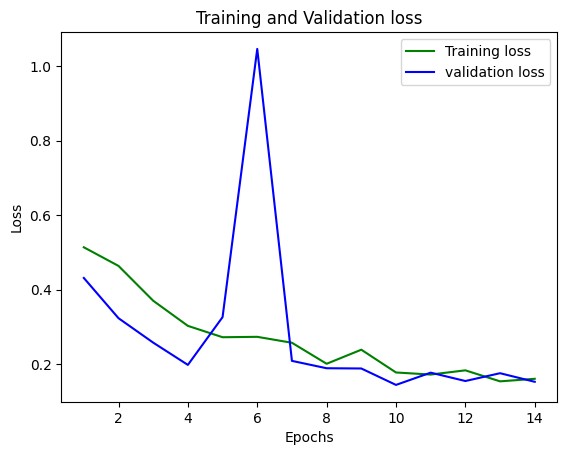

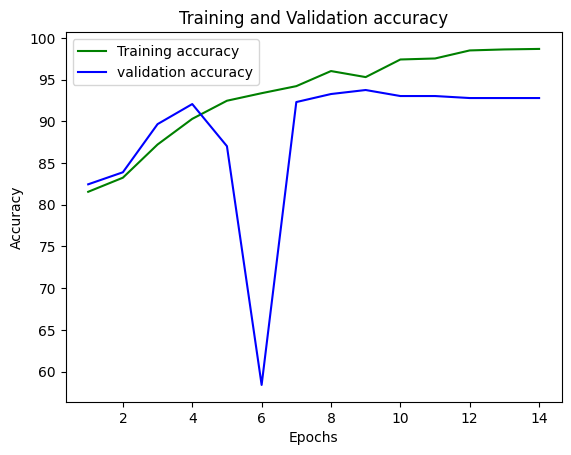

[[325  18]
 [ 12  61]]
True positive =  325
False positive =  18
False negative =  12
True negative =  61




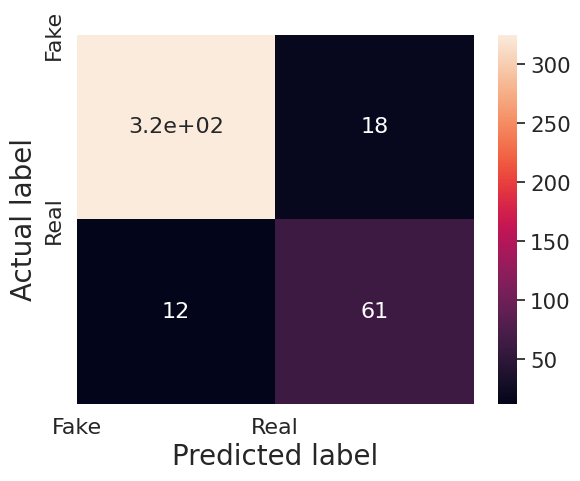

Calculated Accuracy 92.78846153846155


In [19]:
from torch.optim import SGD

# Learning rate
lr = 1e-3  # Increased from 1e-5 to 1e-3
# Number of epochs
num_epochs = 15

optimizer = SGD(model.parameters(), lr=lr, weight_decay=1e-5, momentum=0.9)

criterion = nn.CrossEntropyLoss().cuda()
train_loss_avg = []
train_accuracy = []
test_loss_avg = []
test_accuracy = []

# Variables for early stopping
best_accuracy = 0
patience = 5  # Adjust as needed
early_stopping_counter = 0

# Initialize the scheduler
scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.1, verbose=True)

for epoch in range(1, num_epochs + 1):
    # Training
    train_loss, train_acc = train_epoch(epoch, num_epochs, train_loader, model, criterion, optimizer)
    train_loss_avg.append(train_loss)
    train_accuracy.append(train_acc)
    
    # Validation
    true, pred, test_loss, test_acc = test(epoch, model, valid_loader, criterion)
    test_loss_avg.append(test_loss)
    test_accuracy.append(test_acc)

    # Early stopping
    if test_acc > best_accuracy:
        best_accuracy = test_acc
        early_stopping_counter = 0
    else:
        early_stopping_counter += 1

    if early_stopping_counter >= patience:
        print("Early stopping triggered!")
        break

    # Learning rate scheduling
    scheduler.step(test_loss)

    # Print current learning rate
    for param_group in optimizer.param_groups:
        print(f"Epoch {epoch}: Current learning rate is {param_group['lr']}")

# Plotting, logging, etc.
plot_loss(train_loss_avg, test_loss_avg, len(train_loss_avg))
plot_accuracy(train_accuracy, test_accuracy, len(train_accuracy))
print(confusion_matrix(true, pred))
print_confusion_matrix(true, pred)


In [36]:
#import libraries
!pip3 install face_recognition

import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import face_recognition
     

  Using cached face_recognition-1.3.0-py2.py3-none-any.whl.metadata (21 kB)
  Using cached face_recognition_models-0.3.0.tar.gz (100.1 MB)
  Preparing metadata (setup.py) ... done
  Using cached dlib-19.24.4.tar.gz (3.3 MB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
Using cached face_recognition-1.3.0-py2.py3-none-any.whl (15 kB)
  Created wheel for dlib: filename=dlib-19.24.4-cp310-cp310-linux_x86_64.whl size=3327205 sha256=3d1d4a175efacadaef494ea1e813bfb2e2f58718b49f1b0f2b4fe2300765c95c
  Stored in directory: /root/.cache/pip/wheels/08/5e/55/a7db8d57920eb2c2aa41c36dc4c6d3cd12323865de191a7211
  Created wheel for face-recognition-models: filename=face_recognition_models-0.3.0-py2.py3-none-any.whl size=100566165 sha256=bb0015983fa35e355d8918c0ecbeaf5744124146085e3a369dc7f947c085a82a
  Stored in directory: /root/.cache/pip/wheels/7a/eb/cf/e9eced74122b679557f597bb7c8e4c739cfcac526db1fd523d
Successf

In [37]:
#import libraries
import torch
from torch.autograd import Variable
import time
import os
import sys
import os
from torch import nn
from torchvision import models

In [38]:
from torch import nn
from torchvision import models
class Model(nn.Module):
    def __init__(self, num_classes,latent_dim= 2048, lstm_layers=1 , hidden_dim = 2048, bidirectional = False):
        super(Model, self).__init__()
        model = models.resnext50_32x4d(pretrained = True) #Residual Network CNN
        self.model = nn.Sequential(*list(model.children())[:-2])
        self.lstm = nn.LSTM(latent_dim,hidden_dim, lstm_layers,  bidirectional)
        self.relu = nn.LeakyReLU()
        self.dp = nn.Dropout(0.4)
        self.linear1 = nn.Linear(2048,num_classes)
        self.avgpool = nn.AdaptiveAvgPool2d(1)
    def forward(self, x):
        batch_size,seq_length, c, h, w = x.shape
        x = x.view(batch_size * seq_length, c, h, w)
        fmap = self.model(x)
        x = self.avgpool(fmap)
        x = x.view(batch_size,seq_length,2048)
        x_lstm,_ = self.lstm(x,None)
        return fmap,self.dp(self.linear1(torch.mean(x_lstm,dim = 1)))

In [39]:
im_size = 112
mean=[0.485, 0.456, 0.406]
std=[0.229, 0.224, 0.225]
sm = nn.Softmax()
inv_normalize =  transforms.Normalize(mean=-1*np.divide(mean,std),std=np.divide([1,1,1],std))
def im_convert(tensor):
    """ Display a tensor as an image. """
    image = tensor.to("cpu").clone().detach()
    image = image.squeeze()
    image = inv_normalize(image)
    image = image.numpy()
    image = image.transpose(1,2,0)
    image = image.clip(0, 1)
    cv2.imwrite('./2.png',image*255)
    return image

def predict(model,img,path = './'):
  fmap,logits = model(img.to('cuda'))
  params = list(model.parameters())
  weight_softmax = model.linear1.weight.detach().cpu().numpy()
  logits = sm(logits)
  _,prediction = torch.max(logits,1)
  confidence = logits[:,int(prediction.item())].item()*100
  print('confidence of prediction:',logits[:,int(prediction.item())].item()*100)
  idx = np.argmax(logits.detach().cpu().numpy())
  bz, nc, h, w = fmap.shape
  out = np.dot(fmap[-1].detach().cpu().numpy().reshape((nc, h*w)).T,weight_softmax[idx,:].T)
  predict = out.reshape(h,w)
  predict = predict - np.min(predict)
  predict_img = predict / np.max(predict)
  predict_img = np.uint8(255*predict_img)
  out = cv2.resize(predict_img, (im_size,im_size))
  heatmap = cv2.applyColorMap(out, cv2.COLORMAP_JET)
  img = im_convert(img[:,-1,:,:,:])
  result = heatmap * 0.5 + img*0.8*255
  cv2.imwrite('/content/1.png',result)
  result1 = heatmap * 0.5/255 + img*0.8
  r,g,b = cv2.split(result1)
  result1 = cv2.merge((r,g,b))
  plt.imshow(result1)
  plt.show()
  return [int(prediction.item()),confidence]
#img = train_data[100][0].unsqueeze(0)
#predict(model,img)
     


In [40]:
#!pip3 install face_recognition
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import face_recognition
class validation_dataset(Dataset):
    def __init__(self,video_names,sequence_length = 60,transform = None):
        self.video_names = video_names
        self.transform = transform
        self.count = sequence_length
    def __len__(self):
        return len(self.video_names)
    def __getitem__(self,idx):
        video_path = self.video_names[idx]
        frames = []
        a = int(100/self.count)
        first_frame = np.random.randint(0,a)      
        for i,frame in enumerate(self.frame_extract(video_path)):
            #if(i % a == first_frame):
            faces = face_recognition.face_locations(frame)
            try:
              top,right,bottom,left = faces[0]
              frame = frame[top:bottom,left:right,:]
            except:
              pass
            frames.append(self.transform(frame))
            if(len(frames) == self.count):
              break
        #print("no of frames",len(frames))
        frames = torch.stack(frames)
        frames = frames[:self.count]
        return frames.unsqueeze(0)
    def frame_extract(self,path):
      vidObj = cv2.VideoCapture(path) 
      success = 1
      while success:
          success, image = vidObj.read()
          if success:
              yield image
def im_plot(tensor):
    image = tensor.cpu().numpy().transpose(1,2,0)
    b,g,r = cv2.split(image)
    image = cv2.merge((r,g,b))
    image = image*[0.22803, 0.22145, 0.216989] +  [0.43216, 0.394666, 0.37645]
    image = image*255.0
    plt.imshow(image.astype(int))
    plt.show()
     


/kaggle/input/mixed123/Fake.mp4
confidence of prediction: 89.67713117599487


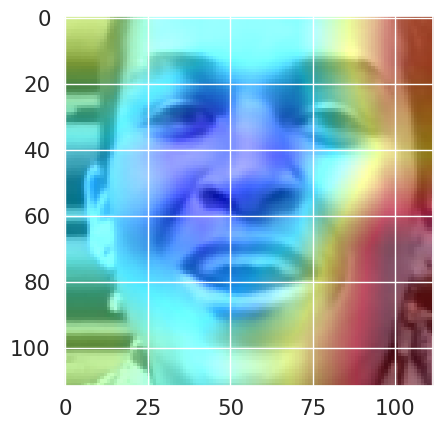

FAKE
/kaggle/input/mixed123/Real2.mp4
confidence of prediction: 72.08442687988281


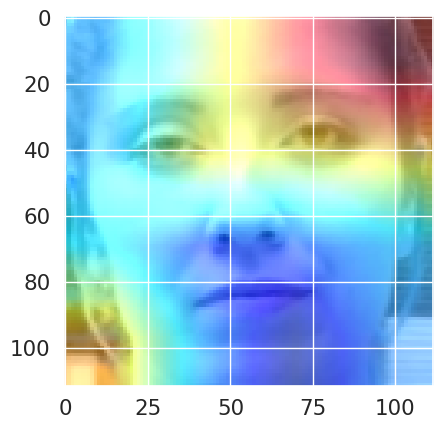

REAL
/kaggle/input/mixed123/Fake2.mp4
confidence of prediction: 83.94352197647095


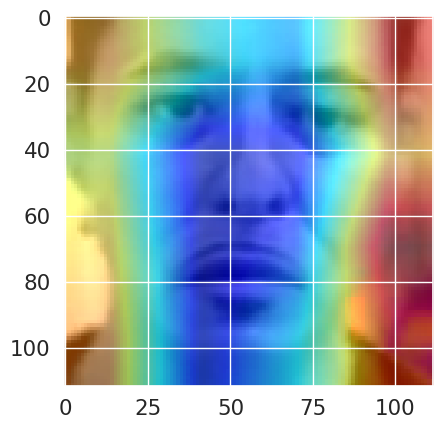

FAKE
/kaggle/input/mixed123/Real.mp4
confidence of prediction: 80.9023916721344


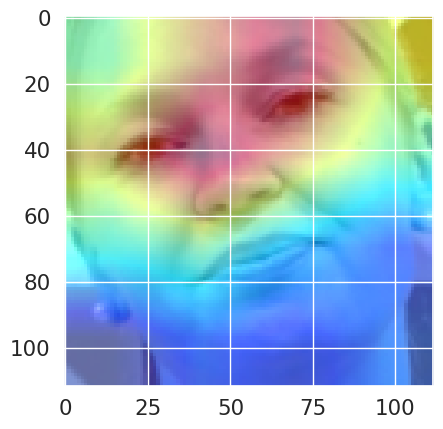

REAL


In [54]:
#Code for making prediction
im_size = 112
mean=[0.485, 0.456, 0.406]
std=[0.229, 0.224, 0.225]

train_transforms = transforms.Compose([
                                        transforms.ToPILImage(),
                                        transforms.Resize((im_size,im_size)),
                                        transforms.ToTensor(),
                                        transforms.Normalize(mean,std)])




path_to_videos= ["/kaggle/input/mixed123/Fake.mp4","/kaggle/input/mixed123/Real2.mp4","/kaggle/input/mixed123/Fake2.mp4","/kaggle/input/mixed123/Real.mp4"]

video_dataset = validation_dataset(path_to_videos,sequence_length = 20,transform = train_transforms)
model = Model(2).cuda()
path_to_model = '/kaggle/working/checkpoint.pt'
model.load_state_dict(torch.load(path_to_model))
model.eval()
for i in range(0,len(path_to_videos)):
  print(path_to_videos[i])
  prediction = predict(model,video_dataset[i],'./')
  if prediction[0] == 1:
    print("REAL")
  else:
    print("FAKE")
